<a href="https://colab.research.google.com/github/desstaw/Shortcut_Learning/blob/main/Waterbirds_224_alexnet_eval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torchextractor

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [ ]:
import torch
import sys
import numpy as np
import pickle as pkl
from os.path import join as oj
from datetime import datetime
import torch.optim as optim
import os
from torch.utils.data import TensorDataset, ConcatDataset
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, f1_score
import argparse
from PIL import Image
from tqdm import tqdm
from torch import nn
from numpy.random import randint
import torchvision.models as models
import time
import copy
import gc
import json
import pandas as pd
import torch
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import DataLoader
from PIL import Image
import torch.nn as nn
import matplotlib.pyplot as plt
import time
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import StepLR
from scipy.stats import ttest_1samp
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount("/content/drive")
dir_path = "/content/drive/MyDrive/Masterthesis/Datasets/Waterbird"
#dir_path = "/content/drive/MyDrive/Projects/ISIC_224"

Mounted at /content/drive


In [ ]:
model_path = oj(dir_path, "models", "initial_classifier")
model_training_path = oj(model_path, "training_224")
data_path = oj(dir_path, "data")

not_waterbird_path = oj(data_path, "processed", "no_waterbird_224")
waterbird_path = oj(data_path, "processed", "waterbird_224")

In [ ]:

import numpy as np
import argparse
import torch
import torchvision.models as models
import torch.nn as nn

mean = np.asarray([0.485, 0.456, 0.406])
std = np.asarray([0.229, 0.224, 0.225])

# Define arguments
class Args:
    def __init__(self):
        self.batch_size = 64
        self.epochs = 100
        self.lr = 0.0001
        self.momentum = 0.9
        self.seed = 111
        self.regularizer_rate = 0.0
        #self.dropout_rate = 0.7

args = Args()

regularizer_rate = args.regularizer_rate
#dropout_rate = args.dropout_rate
num_epochs = args.epochs
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.manual_seed(args.seed)
model = models.alexnet(pretrained=True)
#changing nn.Linear(4096, 1000) to nn.Linear(4096, 2) as alexnet was trained on imagenet with 1000 classes originally
model.classifier[-1] = nn.Linear(4096, 2)
model = model.to(device)

#for module in model.classifier.children():
    #if isinstance(module, nn.Dropout):
        #module.p = dropout_rate

params_to_update = model.parameters()


In [ ]:
def clean_up_empty_files(path):
    list_files= os.listdir(path)
    num_files = len(list_files)
    for i in tqdm(range(num_files)):
        if os.path.getsize(oj(path, list_files[i])) < 100:
            os.remove(oj(path, list_files[i]))
            print("File " + str(i) + "deleted!")

In [ ]:
class WaterbirdDataset(torch.utils.data.Dataset):
    def __init__(self, path: str = None, is_waterbird: int = None, data_files = None, labels = None, group_labels = None):
        """
        Expects path and is_waterbird both to be supplied if the relevant images all lie in the same directory and have the same class
        or a list of full filepaths and list of all labels are both supplied using data_files and labels otherwise.
        """

        """
        Initializes the WaterbirdDataset.

        If 'path' and 'is_waterbird' are provided, it assumes that all images in the directory specified
        by 'path' belong to the same class 'is_waterbird'.

        Alternatively, if 'data_files' and 'labels' are provided, it uses these lists directly
        for file paths and corresponding labels.

        Args:
            path (str): Directory containing images, all belonging to the same class.
            is_waterbird (int): The class label (e.g., 1 for waterbird, 0 for non-waterbird) for all images in the directory.
            data_files (list): List of full file paths to images.
            labels (list): List of labels corresponding to 'data_files'.
        """
        if path: # If a path is provided, list all files in the directory and assign the class label
            self.path = path
            self.data_files = os.listdir(self.path)
            self.is_waterbird = is_waterbird
            self.group_labels = [is_waterbird] * len(self.data_files)  # Assuming group labels are consistent within the directory

        else: # Otherwise, use provided lists of data files and labels
            self.path = ''
            self.data_files = data_files
            self.labels = labels
            self.group_labels = group_labels
            self.is_waterbird = None

    def __getitem__(self, i):

        """
        Retrieves an image and its label at index 'i'.

        Args:
            i (int): Index of the image to retrieve.

        Returns:
            tuple: (image tensor, label)
        """


        # Read in the image, convert to float between [0,1] and standardise , and convert to a PyTorch tensor
        img = Image.open(oj(self.path, self.data_files[i]))
        img_array = np.asarray(img)/255.0 # Convert image to float and scale to [0, 1]
        img_array -= mean[None, None, :] # Subtract the mean for normalization
        img_array /= std[None, None, :] # Divide by the standard deviation for normalization
        img.close()
        torch_img = torch.from_numpy(img_array.swapaxes(0,2).swapaxes(1,2)).float() # Convert the numpy array to a PyTorch tensor and rearrange the axes
        # Determine the label: use the global class label if provided, otherwise extract the relevant label from the list of labels.
        is_waterbird = self.is_waterbird if self.is_waterbird is not None else self.labels[i]
        group_label = self.group_labels[i]
        return (torch_img, is_waterbird, group_label)

    def __len__(self): # Returns the total number of images in the dataset.
        return len(self.data_files)

## Functions for Training

In [ ]:
def gradient_sum(im, target, model, crit, device='cuda'):
    '''Assume that everything is already on cuda.'''
    im.requires_grad = True  # Enable gradient computation for the input image
    grad_params = torch.abs(torch.autograd.grad(crit(model(im), target), im, create_graph=True)[0].sum(dim=1)).sum()
    return grad_params

def train_model(model, dataloaders, criterion, optimizer, num_epochs=100, resume_training=False):
    since = time.time()
    best_loss = 10.0

    scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)  # Example scheduler

    if len(os.listdir(model_training_path)) > 0 and resume_training:
        # Check if there are saved model files and resume training if needed
        model_list = [(f, os.path.getmtime(os.path.join(model_training_path, f))) for f in os.listdir(model_training_path) if f.endswith('.pt')]
        model_list.sort(key=lambda tup: tup[1], reverse=True)  # Sort models by modification time in place from most to least recent
        model_name = model_list[0][0]
        model.load_state_dict(torch.load(os.path.join(model_training_path, model_name)))
        print("Model loaded!")

    # Initialize lists to track loss and accuracy
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(1, num_epochs + 1):
        print(f'Epoch {epoch}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:  # Add 'val' phase
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            running_loss = 0.0
            running_loss_cd = 0.0
            running_corrects = 0

            # Iterate over data, moving inputs and labels to the specified device
            for i, (inputs, labels, group_labels) in tqdm(enumerate(dataloaders[phase]), total=len(dataloaders[phase])):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    if phase == 'train' and regularizer_rate != 0:
                        add_loss = gradient_sum(inputs, labels, model, criterion)
                        if add_loss != 0:
                            (regularizer_rate * add_loss).backward()
                            optimizer.step()
                        optimizer.zero_grad()
                        running_loss_cd += add_loss.item() * inputs.size(0)

                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_cd_loss = running_loss_cd / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} CD Loss: {epoch_cd_loss:.4f}')

            # Append metrics to lists
            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accuracies.append(epoch_acc.cpu().numpy())  # Move accuracy to CPU before appending
            else:
                val_losses.append(epoch_loss)
                val_accuracies.append(epoch_acc.cpu().numpy())  # Move accuracy to CPU before appending

            # Deep copy the model if it's the best one
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        # Step the scheduler
        scheduler.step()

        # Save model checkpoint every 5 epochs
        if epoch % 5 == 0:
            torch.save(model.state_dict(), os.path.join(model_training_path, datetime.now().strftime("%Y%m%d%H%M%S") + "alexnet_wb" + ".pt"))

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val loss: {best_loss:.4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)

    # Plot the training and validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

    # Plot the training and validation accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')
    plt.show()

    return model

## Train

Selective Train (wbw, lbw, lbl)

In [ ]:
# Train
train_wb_nopatch_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/train/train_wb_nopatch'
train_lb_nopatch_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/train/train_lb_nopatch'
train_lb_patch_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/train/train_lb_patch'
train_wb_patch_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/train/train_wb_patch'

dataset_wb_nopatch_train = WaterbirdDataset(path=train_wb_nopatch_path, is_waterbird=1, group_labels=[3] * len(os.listdir(train_wb_nopatch_path)))
dataset_lb_nopatch_train = WaterbirdDataset(path=train_lb_nopatch_path, is_waterbird=0, group_labels=[0] * len(os.listdir(train_lb_nopatch_path)))
dataset_lb_patch_train = WaterbirdDataset(path=train_lb_patch_path, is_waterbird=0, group_labels=[1] * len(os.listdir(train_lb_patch_path)))
dataset_wb_patch_train = WaterbirdDataset(path=train_wb_patch_path, is_waterbird=0, group_labels=[1] * len(os.listdir(train_wb_patch_path)))

# Test

test_wb_nopatch_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/test/test_wb_nopatch'
test_lb_nopatch_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/test/test_lb_nopatch'
test_lb_patch_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/test/test_lb_patch'
test_wb_patch_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/test/test_wb_patch'

dataset_wb_nopatch_test = WaterbirdDataset(path=test_wb_nopatch_path, is_waterbird=1, group_labels=[3] * len(os.listdir(test_wb_nopatch_path)))
dataset_lb_nopatch_test = WaterbirdDataset(path=test_lb_nopatch_path, is_waterbird=0, group_labels=[0] * len(os.listdir(test_lb_nopatch_path)))
dataset_lb_patch_test = WaterbirdDataset(path=test_lb_patch_path, is_waterbird=0, group_labels=[1] * len(os.listdir(test_lb_patch_path)))
dataset_wb_patch_test = WaterbirdDataset(path=test_wb_patch_path, is_waterbird=0, group_labels=[1] * len(os.listdir(test_wb_patch_path)))


# Validate

val_wb_nopatch_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/val/val_wb_nopatch'
val_lb_nopatch_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/val/val_lb_nopatch'
val_lb_patch_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/val/val_lb_patch'
val_wb_patch_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/val/val_wb_patch'

dataset_wb_nopatch_val = WaterbirdDataset(path=val_wb_nopatch_path, is_waterbird=1, group_labels=[3] * len(os.listdir(val_wb_nopatch_path)))
dataset_lb_nopatch_val = WaterbirdDataset(path=val_lb_nopatch_path, is_waterbird=0, group_labels=[0] * len(os.listdir(val_lb_nopatch_path)))
dataset_lb_patch_val = WaterbirdDataset(path=val_lb_patch_path, is_waterbird=0, group_labels=[1] * len(os.listdir(val_lb_patch_path)))
dataset_wb_patch_val = WaterbirdDataset(path=val_wb_patch_path, is_waterbird=0, group_labels=[1] * len(os.listdir(val_wb_patch_path)))



# selective: wbw, lbw, lbl
train_dataset = ConcatDataset((dataset_wb_nopatch_train, dataset_lb_nopatch_train, dataset_lb_patch_train))
test_dataset = dataset_wb_patch_test
val_dataset = ConcatDataset((dataset_wb_nopatch_val, dataset_lb_nopatch_val, dataset_lb_patch_val))

batch_size = args.batch_size

#dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)


dataloaders = {'train': train_loader, 'val': val_loader, 'test': test_loader}
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset), 'test': len(test_dataset)}

# Print dataset sizes
print("num_train:", dataset_sizes['train'])
print("num_test:", dataset_sizes['test'])

# Example usage:
group_frequencies = {
    0: 3518,  # landbird_generic-spurious:birdonland
    1: 185,   # landbird_generic-spurious:birdonwater
    2: 55,    # waterbird_generic-spurious:birdonland
    3: 1037   # waterbird_generic-spurious:birdonwater
}



num_train: 3758
num_test: 642


In [ ]:
wb_ratio = len(dataset_wb_nopatch_train)/len(train_dataset)

not_wb_ratio = 1 - wb_ratio
wb_weight = 1/wb_ratio
not_wb_weight = 1/ not_wb_ratio
weights = np.asarray([not_wb_weight, wb_weight])
weights /= weights.sum()
weights = torch.tensor(weights).to(device)

criterion = nn.CrossEntropyLoss(weight = weights.double().float())

mean = np.asarray([0.485, 0.456, 0.406])
std = np.asarray([0.229, 0.224, 0.225])


# Define arguments
class Args:
    def __init__(self):
        self.batch_size = 64
        self.epochs = 100
        self.lr = 0.0001
        self.momentum = 0.9
        self.seed = 111
        self.regularizer_rate = 0.0

args = Args()

regularizer_rate = args.regularizer_rate
num_epochs = args.epochs

torch.manual_seed(args.seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
#params_to_update = model.classifier.parameters()
params_to_update = model.parameters()

optimizer_ft = optim.SGD(params_to_update, lr=args.lr, momentum=args.momentum)

In [ ]:
model = train_model(model, dataloaders, criterion, optimizer_ft, num_epochs=num_epochs, resume_training=False)
pid = datetime.now().strftime('%Y%m%d%H%M%S')
torch.save(model.state_dict(), os.path.join(dir_path, model_path, pid + "alexnet_wbw_lbl_lbw_3_" +"train.pt"))

Epoch 1/100
----------


In [ ]:
stophere

Selective train (wbw, lbl)

In [ ]:
wb_nopatch_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/balanced_data/wb_no_patch'
lb_nopatch_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/balanced_data/lb_no_patch'
lb_patch_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/balanced_data/lb_patch'
wb_patch_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/balanced_data/wb_patch'




# Create datasets for training and testing
dataset_wb_nopatch = WaterbirdDataset(path=wb_nopatch_path, is_waterbird=1, group_labels=[3] * len(os.listdir(wb_nopatch_path)))
dataset_lb_nopatch = WaterbirdDataset(path=lb_nopatch_path, is_waterbird=0, group_labels=[0] * len(os.listdir(lb_nopatch_path)))
dataset_lb_patch = WaterbirdDataset(path=lb_patch_path, is_waterbird=0, group_labels=[1] * len(os.listdir(lb_patch_path)))
dataset_wb_patch = WaterbirdDataset(path=wb_patch_path, is_waterbird=0, group_labels=[1] * len(os.listdir(wb_patch_path)))


complete_dataset = ConcatDataset((dataset_wb_nopatch, dataset_lb_nopatch))
train_dataset = complete_dataset
test_dataset = dataset_wb_patch

batch_size = args.batch_size  # Assuming args.batch_size is defined

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
dataloaders = {'train': train_loader, 'test': test_loader}
dataset_sizes = {'train': len(train_dataset), 'test': len(test_dataset)}

# Print dataset sizes
print("num_train:", dataset_sizes['train'])
print("num_test:", dataset_sizes['test'])

# Example usage:
group_frequencies = {
    0: 3518,  # landbird_generic-spurious:birdonland
    1: 185,   # landbird_generic-spurious:birdonwater
    2: 55,    # waterbird_generic-spurious:birdonland
    3: 1037   # waterbird_generic-spurious:birdonwater
}



In [ ]:
wb_ratio = len(dataset_wb_nopatch)/len(complete_dataset)

not_wb_ratio = 1 - wb_ratio
wb_weight = 1/wb_ratio
not_wb_weight = 1/ not_wb_ratio
weights = np.asarray([not_wb_weight, wb_weight])
weights /= weights.sum()
weights = torch.tensor(weights).to(device)

criterion = nn.CrossEntropyLoss(weight = weights.double().float())

mean = np.asarray([0.485, 0.456, 0.406])
std = np.asarray([0.229, 0.224, 0.225])


# Define arguments
class Args:
    def __init__(self):
        self.batch_size = 64
        self.epochs = 100
        self.lr = 0.0001
        self.momentum = 0.9
        self.seed = 1
        self.regularizer_rate = 0.0

args = Args()

regularizer_rate = args.regularizer_rate
num_epochs = args.epochs

torch.manual_seed(args.seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
#params_to_update = model.classifier.parameters()
params_to_update = model.parameters()

optimizer_ft = optim.SGD(params_to_update, lr=args.lr, momentum=args.momentum)

In [ ]:
model = train_model(model, dataloaders, criterion, optimizer_ft, num_epochs=num_epochs, resume_training=False)
pid = datetime.now().strftime('%Y%m%d%H%M%S')
torch.save(model.state_dict(), os.path.join(dir_path, model_path, pid + "alexnet_wbw_lbl_1_" +"train.pt"))

Full train

In [ ]:
wb_nopatch_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/balanced_data/wb_no_patch'
lb_nopatch_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/balanced_data/lb_no_patch'
lb_patch_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/balanced_data/lb_patch'
wb_patch_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/balanced_data/wb_patch'




# Create datasets for training and testing
dataset_wb_nopatch = WaterbirdDataset(path=wb_nopatch_path, is_waterbird=1, group_labels=[3] * len(os.listdir(wb_nopatch_path)))
dataset_lb_nopatch = WaterbirdDataset(path=lb_nopatch_path, is_waterbird=0, group_labels=[0] * len(os.listdir(lb_nopatch_path)))
dataset_lb_patch = WaterbirdDataset(path=lb_patch_path, is_waterbird=0, group_labels=[1] * len(os.listdir(lb_patch_path)))
dataset_wb_patch = WaterbirdDataset(path=wb_patch_path, is_waterbird=0, group_labels=[1] * len(os.listdir(wb_patch_path)))


complete_dataset = ConcatDataset((dataset_wb_nopatch, dataset_lb_nopatch, dataset_lb_patch, dataset_wb_patch))
dataset_wb = ConcatDataset((dataset_wb_nopatch, dataset_wb_patch))
train_dataset = complete_dataset
test_dataset = dataset_wb_patch

batch_size = args.batch_size  # Assuming args.batch_size is defined

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
dataloaders = {'train': train_loader, 'test': test_loader}
dataset_sizes = {'train': len(train_dataset), 'test': len(test_dataset)}

# Print dataset sizes
print("num_train:", dataset_sizes['train'])
print("num_test:", dataset_sizes['test'])

# Example usage:
group_frequencies = {
    0: 840,  # landbird_generic-spurious:birdonland
    1: 840,   # landbird_generic-spurious:birdonwater
    2: 840,    # waterbird_generic-spurious:birdonland
    3: 840   # waterbird_generic-spurious:birdonwater
}



In [ ]:
wb_ratio = len(dataset_wb)/len(complete_dataset)

not_wb_ratio = 1 - wb_ratio
wb_weight = 1/wb_ratio
not_wb_weight = 1/ not_wb_ratio
weights = np.asarray([not_wb_weight, wb_weight])
weights /= weights.sum()
weights = torch.tensor(weights).to(device)

criterion = nn.CrossEntropyLoss(weight = weights.double().float())


# Define arguments
class Args:
    def __init__(self):
        self.batch_size = 16
        self.epochs = 100
        self.lr = 0.00001
        self.momentum = 0.9
        self.seed = 42
        self.regularizer_rate = 0.0

args = Args()

regularizer_rate = args.regularizer_rate
num_epochs = args.epochs

torch.manual_seed(args.seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
#params_to_update = model.classifier.parameters()
params_to_update = model.parameters()

optimizer_ft = optim.SGD(params_to_update, lr=args.lr, momentum=args.momentum)

In [ ]:
model = train_model(model, dataloaders, criterion, optimizer_ft, num_epochs=num_epochs, resume_training=False)
pid = datetime.now().strftime('%Y%m%d%H%M%S')
torch.save(model.state_dict(), os.path.join(dir_path, model_path, pid + "full_train_full_model.pt"))

## Functions for Evaluation

### Evaluation Metrics

In [ ]:
import torch
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, brier_score_loss, log_loss, precision_score, recall_score
import matplotlib.pyplot as plt

def get_output(model, dataset, device, batch_size=64):
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    model.eval()
    y_list = []
    y_hat_list = []
    group_labels_list = []
    softmax = torch.nn.Softmax(dim=1)

    with torch.no_grad():
        for data in data_loader:
            inputs, labels, group_labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            y_list.append(labels.cpu().numpy())
            y_hat_list.append(softmax(outputs).cpu().numpy()[:, 1])  # Extract probabilities for the positive class
            group_labels_list.append(group_labels.cpu().numpy())

    if not y_list or not y_hat_list or not group_labels_list:
        print("Warning: One or more lists are empty.")
        return None

    y = np.concatenate(y_list)
    y_hat = np.concatenate(y_hat_list)
    group_labels = np.concatenate(group_labels_list)

    # Convert probabilities to binary predictions
    preds = (y_hat >= 0.5).astype(int)

    # Calculate TP, TN, FP, FN
    tp = ((preds == 1) & (y == 1)).sum()
    tn = ((preds == 0) & (y == 0)).sum()
    fp = ((preds == 1) & (y == 0)).sum()
    fn = ((preds == 0) & (y == 1)).sum()

    # Print intermediate results for debugging
    print(f'TP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}')
    print(f'y: {np.bincount(y)}, preds: {np.bincount(preds)}')  # Check distribution of labels and predictions

    return y, y_hat, group_labels, tp, tn, fp, fn

def get_auc_f1_acc_adj(model, dataset, group_frequencies, fname=None):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    if fname is not None:
        with open(fname, 'rb') as f:
            weights = torch.load(f)
        if "classifier.0.weight" in weights.keys():
            model.load_state_dict(weights)
        else:
            model.load_state_dict(weights)
        output = get_output(model, dataset, device)
    else:
        output = get_output(model, dataset, device)

    if output is None:
        print("Error: get_output returned None.")
        return None

    y, y_hat, group_labels, tp, tn, fp, fn = output

    unique_classes = np.unique(group_labels)
    if len(unique_classes) < 2:
        print("Warning: Test dataset has only one class. Metrics like ROC AUC and F1 Score cannot be computed.")
        acc = accuracy_score(y, (y_hat >= 0.5).astype(int))
        brier = brier_score_loss(y, y_hat)
        tpr = tp / (tp + fn) if (tp + fn) > 0 else None
        recall = tpr

        normal_metrics = (None, None, acc, tp, tn, fp, fn, brier, tpr)

        return {
            "normal": normal_metrics
        }

    threshold = 0.5
    y_pred = (y_hat >= threshold).astype(int)
    auc_score = roc_auc_score(y, y_hat)
    f1 = f1_score(y, y_pred)
    acc = accuracy_score(y, y_pred)
    brier = brier_score_loss(y, y_pred)
    nll = log_loss(y, y_pred)
    tpr = tp / (tp + fn) if (tp + fn) > 0 else None
    precision = tp / (tp + fp) if (tp + fp) > 0 else None
    recall = recall_score(y, y_pred)

    normal_metrics = (auc_score, f1, acc, tp, tn, fp, fn, brier, tpr)

    return {
        "normal": normal_metrics
    }


## Experiment 1:



   

### Baseline Performance Test:
Use the full training dataset: wb_patch, wb_no_patvh, lb_patch and lb_no_patch. For the first test we use wb_no_patch and for the second we use wb_patch.

with patch:

In [ ]:
train_wb_nopatch_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/train/train_wb_nopatch'
train_lb_nopatch_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/train/train_lb_nopatch'
train_lb_patch_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/train/train_lb_patch'
train_wb_patch_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/train/train_wb_patch'


test_patch_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/test/test_wb_patch'
test_nopatch_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/test/test_wb_nopatch'


# Create datasets for training and testing
train_dataset_wb_nopatch = WaterbirdDataset(path=train_wb_nopatch_path, is_waterbird=1, group_labels=[3] * len(os.listdir(train_wb_nopatch_path)))
train_dataset_lb_nopatch = WaterbirdDataset(path=train_lb_nopatch_path, is_waterbird=0, group_labels=[0] * len(os.listdir(train_lb_nopatch_path)))
train_dataset_lb_patch = WaterbirdDataset(path=train_lb_patch_path, is_waterbird=0, group_labels=[1] * len(os.listdir(train_lb_patch_path)))
train_dataset_wb_patch = WaterbirdDataset(path=train_wb_patch_path, is_waterbird=1, group_labels=[2] * len(os.listdir(train_wb_patch_path)))

test_patch_dataset = WaterbirdDataset(path=test_patch_path, is_waterbird=1, group_labels=[2] * len(os.listdir(test_patch_path)))
test_nopatch_dataset = WaterbirdDataset(path=test_nopatch_path, is_waterbird=1, group_labels=[3] * len(os.listdir(test_nopatch_path)))


train_dataset = ConcatDataset((train_dataset_wb_nopatch, train_dataset_lb_nopatch, train_dataset_lb_patch, train_dataset_wb_patch))


# Example usage:
group_frequencies = {
    0: 3518,  # landbird_generic-spurious:birdonland
    1: 185,   # landbird_generic-spurious:birdonwater
    2: 55,    # waterbird_generic-spurious:birdonland
    3: 1037   # waterbird_generic-spurious:birdonwater
}


#print('test dataset', test_dataset)

# Create dataloaders for training and testing datasets
batch_size = args.batch_size  # Assuming args.batch_size is defined

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_patch_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Organize dataloaders and dataset sizes in dictionaries
dataloaders = {'train': train_loader, 'test': test_loader}
dataset_sizes = {'train': len(train_dataset), 'test': len(test_patch_dataset)}

# Print dataset sizes
print("num_train:", dataset_sizes['train'])
print("num_test:", dataset_sizes['test'])

concat train_wb_patch and train_wb_no_patch and pass them in the first len(train_dataset)

In [ ]:
train_wb_dataset = ConcatDataset((train_dataset_wb_nopatch, train_dataset_wb_patch))
waterbird_ratio = len(train_wb_dataset) / (len(train_dataset))

not_waterbird_ratio = 1 - waterbird_ratio
waterbird_weight = 1/waterbird_ratio
not_waterbird_weight = 1/ not_waterbird_ratio
weights = np.asarray([not_waterbird_weight, waterbird_weight])
weights /= weights.sum()
weights = torch.tensor(weights).to(device)

criterion = nn.CrossEntropyLoss(weight = weights.double().float())


# Define arguments
class Args:
    def __init__(self):
        self.batch_size = 16
        self.epochs = 100
        self.lr = 0.00001
        self.momentum = 0.9
        self.seed = 42
        self.regularizer_rate = 0.0

args = Args()

regularizer_rate = args.regularizer_rate
num_epochs = args.epochs

torch.manual_seed(args.seed)

params_to_update = model.parameters()

optimizer_ft = optim.SGD(params_to_update, lr=args.lr, momentum=args.momentum)

In [ ]:
# Initialize AlexNet with modified classifier
#um_classes = 2
model = models.alexnet(weights=None)

model.classifier[-1] = nn.Linear(4096, 2)

# path to saved model state dictionary
saved_model_path = "/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/models/initial_classifier/20240710132545full_train_full_model.pt"

# Load the saved model state dictionary
state_dict = torch.load(saved_model_path)

# Load only the classifier part from state_dict
model.load_state_dict(state_dict)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Ensure model is in evaluation mode
#model.eval()

In [ ]:
# Assuming model, test_dataset, and group_frequencies are already defined
results = get_auc_f1_acc_adj(model, test_patch_dataset, group_frequencies)

if results and results["normal"] is not None:
    # Retrieve results for normal evaluation
    normal_metrics = results["normal"]
    auc, f1, acc, tp, tn, fp, fn, brier, tpr = normal_metrics

    print(f"Normal Evaluation - AUC: {auc}, F1: {f1}, Accuracy: {acc}, Brier Score: {brier}, TPR: {tpr}")
    print(f"True Positives: {tp}, True Negatives: {tn}, False Positives: {fp}, False Negatives: {fn}")
else:
    print("Normal Evaluation metrics cannot be computed due to a single class in the test dataset or another error.")

without patch:

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_nopatch_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Organize dataloaders and dataset sizes in dictionaries
dataloaders = {'train': train_loader, 'test': test_loader}
dataset_sizes = {'train': len(train_dataset), 'test': len(test_nopatch_dataset)}

print("num_train:", dataset_sizes['train'])
print("num_test:", dataset_sizes['test'])

In [ ]:
# Assuming model, test_dataset, and group_frequencies are already defined
results = get_auc_f1_acc_adj(model, test_nopatch_dataset, group_frequencies)

if results and results["normal"] is not None:
    # Retrieve results for normal evaluation
    normal_metrics = results["normal"]
    auc, f1, acc, tp, tn, fp, fn, brier, tpr = normal_metrics

    print(f"Normal Evaluation - AUC: {auc}, F1: {f1}, Accuracy: {acc}, Brier Score: {brier}, TPR: {tpr}")
    print(f"True Positives: {tp}, True Negatives: {tn}, False Positives: {fp}, False Negatives: {fn}")
else:
    print("Normal Evaluation metrics cannot be computed due to a single class in the test dataset or another error.")



---



### Main Experiment

Introducing a new test set with spurious features that were not present in the trainig set

**Hypothesis**: Accuracy, Adj_Acc, TPs and Brier Score drop when testing with wb_patch after wb_no_patch.

**Design**:

*   Training set: on wb_no patch, lb_patch and lb_no patch.
*   Testing sets: first run on *wb_no_patch* and second run on *wb_patch*

**Evaluation Metrics:** Accuracy, Adj_Acc, TPs, FNs and Brier Score

**Results:**

no patch

In [ ]:
train_wb_nopatch_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/train/train_wb_nopatch'
train_lb_nopatch_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/train/train_lb_nopatch'
train_lb_patch_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/train/train_lb_patch'

test_patch_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/test/test_wb_patch'
test_nopatch_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/test/test_wb_nopatch'


# Create datasets for training and testing
train_dataset_wb_nopatch = WaterbirdDataset(path=train_wb_nopatch_path, is_waterbird=1, group_labels=[3] * len(os.listdir(train_wb_nopatch_path)))
train_dataset_lb_nopatch = WaterbirdDataset(path=train_lb_nopatch_path, is_waterbird=0, group_labels=[0] * len(os.listdir(train_lb_nopatch_path)))
train_dataset_lb_patch = WaterbirdDataset(path=train_lb_patch_path, is_waterbird=0, group_labels=[1] * len(os.listdir(train_lb_patch_path)))

test_patch_dataset = WaterbirdDataset(path=test_patch_path, is_waterbird=1, group_labels=[2] * len(os.listdir(test_patch_path)))
test_nopatch_dataset = WaterbirdDataset(path=test_nopatch_path, is_waterbird=1, group_labels=[3] * len(os.listdir(test_nopatch_path)))


train_dataset = ConcatDataset((train_dataset_wb_nopatch, train_dataset_lb_nopatch, train_dataset_lb_patch))


# Example usage:
group_frequencies = {
    0: 3518,  # landbird_generic-spurious:birdonland
    1: 185,   # landbird_generic-spurious:birdonwater
    2: 55,    # waterbird_generic-spurious:birdonland
    3: 1037   # waterbird_generic-spurious:birdonwater
}


#print('test dataset', test_dataset)

# Create dataloaders for training and testing datasets
batch_size = args.batch_size  # Assuming args.batch_size is defined

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_nopatch_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Organize dataloaders and dataset sizes in dictionaries
dataloaders = {'train': train_loader, 'test': test_loader}
dataset_sizes = {'train': len(train_dataset), 'test': len(test_nopatch_dataset)}

# Print dataset sizes
print("num_train:", dataset_sizes['train'])
print("num_test:", dataset_sizes['test'])

In [ ]:
mean = np.asarray([0.485, 0.456, 0.406])
std = np.asarray([0.229, 0.224, 0.225])

# Define arguments
class Args:
    def __init__(self):
        self.batch_size = 16
        self.epochs = 4
        self.lr = 0.00001
        self.momentum = 0.9
        self.seed = 42
        self.regularizer_rate = 0.0

args = Args()

regularizer_rate = args.regularizer_rate
num_epochs = args.epochs
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.manual_seed(args.seed)
model = models.alexnet(pretrained=True)
#changing nn.Linear(4096, 1000) to nn.Linear(4096, 2) as alexnet was trained on imagenet with 1000 classes originally
model.classifier[-1] = nn.Linear(4096, 2)
model = model.to(device)
params_to_update = model.parameters()

In [ ]:
waterbird_ratio = len(train_dataset_wb_nopatch) / (len(train_dataset))

not_waterbird_ratio = 1 - waterbird_ratio
waterbird_weight = 1/waterbird_ratio
not_waterbird_weight = 1/ not_waterbird_ratio
weights = np.asarray([not_waterbird_weight, waterbird_weight])
weights /= weights.sum()
weights = torch.tensor(weights).to(device)

criterion = nn.CrossEntropyLoss(weight = weights.double().float())

optimizer_ft = optim.SGD(params_to_update, lr=args.lr, momentum=args.momentum)

In [ ]:
#model = train_model(model, dataloaders, criterion, optimizer_ft, num_epochs=num_epochs, resume_training=False)
#pid = datetime.now().strftime('%Y%m%d%H%M%S')
#torch.save(model.classifier.state_dict(),oj(dir_path, model_path, pid + ".pt"))

In [ ]:
# Initialize AlexNet with modified classifier
#um_classes = 2
model = models.alexnet(weights=None)

model.classifier[-1] = nn.Linear(4096, 2)


saved_model_path = "/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/models/initial_classifier/20240710123002selective_train_full_model.pt"

# Load the saved model state dictionary
state_dict = torch.load(saved_model_path)

# Load only the classifier part from state_dict
model.load_state_dict(state_dict)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Ensure model is in evaluation mode
#model.eval()

In [ ]:
# Assuming model, test_dataset, and group_frequencies are already defined
results = get_auc_f1_acc_adj(model, test_nopatch_dataset, group_frequencies)

if results and results["normal"] is not None:
    # Retrieve results for normal evaluation
    normal_metrics = results["normal"]
    auc, f1, acc, tp, tn, fp, fn, brier, tpr = normal_metrics

    print(f"Normal Evaluation - AUC: {auc}, F1: {f1}, Accuracy: {acc}, Brier Score: {brier}, TPR: {tpr}")
    print(f"True Positives: {tp}, True Negatives: {tn}, False Positives: {fp}, False Negatives: {fn}")
else:
    print("Normal Evaluation metrics cannot be computed due to a single class in the test dataset or another error.")

patch

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_patch_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Organize dataloaders and dataset sizes in dictionaries
dataloaders = {'train': train_loader, 'test': test_loader}
dataset_sizes = {'train': len(train_dataset), 'test': len(test_patch_dataset)}

print("num_train:", dataset_sizes['train'])
print("num_test:", dataset_sizes['test'])

In [ ]:
# Assuming model, test_dataset, and group_frequencies are already defined
results = get_auc_f1_acc_adj(model, test_patch_dataset, group_frequencies)

if results and results["normal"] is not None:
    # Retrieve results for normal evaluation
    normal_metrics = results["normal"]
    auc, f1, acc, tp, tn, fp, fn, brier, tpr = normal_metrics

    print(f"Normal Evaluation - AUC: {auc}, F1: {f1}, Accuracy: {acc}, Brier Score: {brier}, TPR: {tpr}")
    print(f"True Positives: {tp}, True Negatives: {tn}, False Positives: {fp}, False Negatives: {fn}")
else:
    print("Normal Evaluation metrics cannot be computed due to a single class in the test dataset or another error.")

## Experiment 2

Compare the drop in AUC, ACC, Acc_Adj, F!, Brier by running 2 subtests.
Test 1: wb_patch, wb_no_patch, lb_patch and lb_no_patch
Test 2:  wb_no_patch, lb_patch and lb_no_patch

###  Baseline Performance Test:


test on all but without patch on full training

In [ ]:
train_wb_nopatch_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/train/train_wb_nopatch'
train_lb_nopatch_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/train/train_lb_nopatch'
train_lb_patch_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/train/train_lb_patch'
train_wb_patch_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/train/train_wb_patch'


#test_wb_patch_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/test/test_wb_patch'
test_wb_nopatch_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/test/test_wb_nopatch'
test_lb_patch_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/test/test_lb_patch'
test_lb_nopatch_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/test/test_lb_nopatch'


# Create datasets for training and testing
train_dataset_wb_nopatch = WaterbirdDataset(path=train_wb_nopatch_path, is_waterbird=1, group_labels=[3] * len(os.listdir(train_wb_nopatch_path)))
train_dataset_lb_nopatch = WaterbirdDataset(path=train_lb_nopatch_path, is_waterbird=0, group_labels=[0] * len(os.listdir(train_lb_nopatch_path)))
train_dataset_lb_patch = WaterbirdDataset(path=train_lb_patch_path, is_waterbird=0, group_labels=[1] * len(os.listdir(train_lb_patch_path)))
train_dataset_wb_patch = WaterbirdDataset(path=train_wb_patch_path, is_waterbird=0, group_labels=[1] * len(os.listdir(train_wb_patch_path)))

#test_wb_patch_dataset = WaterbirdDataset(path=test_wb_patch_path, is_waterbird=1, group_labels=[2] * len(os.listdir(test_wb_patch_path)))
test_wb_nopatch_dataset = WaterbirdDataset(path=test_wb_nopatch_path, is_waterbird=1, group_labels=[3] * len(os.listdir(test_wb_nopatch_path)))
test_lb_patch_dataset = WaterbirdDataset(path=test_lb_patch_path, is_waterbird=0, group_labels=[2] * len(os.listdir(test_lb_patch_path)))
test_lb_nopatch_dataset = WaterbirdDataset(path=test_lb_nopatch_path, is_waterbird=0, group_labels=[3] * len(os.listdir(test_lb_nopatch_path)))


train_dataset = ConcatDataset((train_dataset_wb_nopatch, train_dataset_lb_nopatch, train_dataset_lb_patch, train_dataset_wb_patch))
test_dataset = ConcatDataset((test_wb_nopatch_dataset, test_lb_patch_dataset, test_lb_nopatch_dataset))



group_frequencies = {
    0: 3518,  # landbird_generic-spurious:birdonland
    1: 185,   # landbird_generic-spurious:birdonwater
    2: 55,    # waterbird_generic-spurious:birdonland
    3: 1037   # waterbird_generic-spurious:birdonwater
}


#print('test dataset', test_dataset)

# Create dataloaders for training and testing datasets
batch_size = args.batch_size

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Organize dataloaders and dataset sizes in dictionaries
dataloaders = {'train': train_loader, 'test': test_loader}
dataset_sizes = {'train': len(train_dataset), 'test': len(test_dataset)}

# Print dataset sizes
print("num_train:", dataset_sizes['train'])
print("num_test:", dataset_sizes['test'])

adjust train dataset

In [ ]:
train_wb_dataset = ConcatDataset((train_dataset_wb_nopatch, train_dataset_wb_patch))
waterbird_ratio = len(train_wb_dataset) / (len(train_dataset))

not_waterbird_ratio = 1 - waterbird_ratio
waterbird_weight = 1/waterbird_ratio
not_waterbird_weight = 1/ not_waterbird_ratio
weights = np.asarray([not_waterbird_weight, waterbird_weight])
weights /= weights.sum()
weights = torch.tensor(weights).to(device)

criterion = nn.CrossEntropyLoss(weight = weights.double().float())


# Define arguments
class Args:
    def __init__(self):
        self.batch_size = 16
        self.epochs = 10
        self.lr = 0.00001
        self.momentum = 0.9
        self.seed = 42
        self.regularizer_rate = 0.0

args = Args()

regularizer_rate = args.regularizer_rate
num_epochs = args.epochs

torch.manual_seed(args.seed)

params_to_update = model.parameters()

optimizer_ft = optim.SGD(params_to_update, lr=args.lr, momentum=args.momentum)

In [ ]:
# Initialize AlexNet with modified classifier
#um_classes = 2
model = models.alexnet(weights=None)

model.classifier[-1] = nn.Linear(4096, 2)

# path to saved model state dictionary
saved_model_path = "/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/models/initial_classifier/20240710132545full_train_full_model.pt"

# Load the saved model state dictionary
state_dict = torch.load(saved_model_path)

# Load only the classifier part from state_dict
model.load_state_dict(state_dict)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Ensure model is in evaluation mode
#model.eval()

In [ ]:
# Assuming model, test_dataset, and group_frequencies are already defined
results = get_auc_f1_acc_adj(model, test_dataset, group_frequencies)

if results and results["normal"] is not None:
    # Retrieve results for normal evaluation
    normal_metrics = results["normal"]
    auc, f1, acc, tp, tn, fp, fn, brier, tpr = normal_metrics

    print(f"Normal Evaluation - AUC: {auc}, F1: {f1}, Accuracy: {acc}, Brier Score: {brier}, TPR: {tpr}")
    print(f"True Positives: {tp}, True Negatives: {tn}, False Positives: {fp}, False Negatives: {fn}")
else:
    print("Normal Evaluation metrics cannot be computed due to a single class in the test dataset or another error.")

test on all on full train

In [ ]:
# Assuming WaterbirdDataset class can take a directory of images
train_wb_nopatch_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/train/train_wb_nopatch'
train_lb_nopatch_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/train/train_lb_nopatch'
train_lb_patch_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/train/train_lb_patch'
train_wb_patch_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/train/train_wb_patch'


test_wb_patch_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/test/test_wb_patch'
test_wb_nopatch_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/test/test_wb_nopatch'
test_lb_patch_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/test/test_lb_patch'
test_lb_nopatch_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/test/test_lb_nopatch'


# Create datasets for training and testing
train_dataset_wb_nopatch = WaterbirdDataset(path=train_wb_nopatch_path, is_waterbird=1, group_labels=[3] * len(os.listdir(train_wb_nopatch_path)))
train_dataset_lb_nopatch = WaterbirdDataset(path=train_lb_nopatch_path, is_waterbird=0, group_labels=[0] * len(os.listdir(train_lb_nopatch_path)))
train_dataset_lb_patch = WaterbirdDataset(path=train_lb_patch_path, is_waterbird=0, group_labels=[1] * len(os.listdir(train_lb_patch_path)))
train_dataset_wb_patch = WaterbirdDataset(path=train_wb_patch_path, is_waterbird=0, group_labels=[1] * len(os.listdir(train_wb_patch_path)))

test_wb_patch_dataset = WaterbirdDataset(path=test_wb_patch_path, is_waterbird=1, group_labels=[2] * len(os.listdir(test_wb_patch_path)))
test_wb_nopatch_dataset = WaterbirdDataset(path=test_wb_nopatch_path, is_waterbird=1, group_labels=[3] * len(os.listdir(test_wb_nopatch_path)))
test_lb_patch_dataset = WaterbirdDataset(path=test_lb_patch_path, is_waterbird=0, group_labels=[2] * len(os.listdir(test_lb_patch_path)))
test_lb_nopatch_dataset = WaterbirdDataset(path=test_lb_nopatch_path, is_waterbird=0, group_labels=[3] * len(os.listdir(test_lb_nopatch_path)))


train_dataset = ConcatDataset((train_dataset_wb_nopatch, train_dataset_lb_nopatch, train_dataset_lb_patch, train_dataset_wb_patch))
test_dataset = ConcatDataset((test_wb_patch_dataset, test_wb_nopatch_dataset, test_lb_patch_dataset, test_lb_nopatch_dataset))



# Example usage:
group_frequencies = {
    0: 3518,  # landbird_generic-spurious:birdonland
    1: 185,   # landbird_generic-spurious:birdonwater
    2: 55,    # waterbird_generic-spurious:birdonland
    3: 1037   # waterbird_generic-spurious:birdonwater
}


#print('test dataset', test_dataset)

# Create dataloaders for training and testing datasets
batch_size = args.batch_size  # Assuming args.batch_size is defined

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Organize dataloaders and dataset sizes in dictionaries
dataloaders = {'train': train_loader, 'test': test_loader}
dataset_sizes = {'train': len(train_dataset), 'test': len(test_dataset)}

# Print dataset sizes
print("num_train:", dataset_sizes['train'])
print("num_test:", dataset_sizes['test'])

concat train_wb_patch and train_wb_no_patch and pass them in the first len(train_dataset)

patch

In [ ]:
# Assuming model, test_dataset, and group_frequencies are already defined
results = get_auc_f1_acc_adj(model, test_dataset, group_frequencies)

if results and results["normal"] is not None:
    # Retrieve results for normal evaluation
    normal_metrics = results["normal"]
    auc, f1, acc, tp, tn, fp, fn, brier, tpr = normal_metrics

    print(f"Normal Evaluation - AUC: {auc}, F1: {f1}, Accuracy: {acc}, Brier Score: {brier}, TPR: {tpr}")
    print(f"True Positives: {tp}, True Negatives: {tn}, False Positives: {fp}, False Negatives: {fn}")
else:
    print("Normal Evaluation metrics cannot be computed due to a single class in the test dataset or another error.")

### Main Experiment:


---



test on all but except wb without patch  on train without wb patch

In [ ]:

train_wb_nopatch_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/train/train_wb_nopatch'
train_lb_nopatch_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/train/train_lb_nopatch'
train_lb_patch_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/train/train_lb_patch'
#train_wb_patch_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/train/train_wb_patch'


#test_wb_patch_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/test/test_wb_patch'
test_wb_nopatch_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/test/test_wb_nopatch'
test_lb_patch_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/test/test_lb_patch'
test_lb_nopatch_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/test/test_lb_nopatch'


# Create datasets for training and testing
train_dataset_wb_nopatch = WaterbirdDataset(path=train_wb_nopatch_path, is_waterbird=1, group_labels=[3] * len(os.listdir(train_wb_nopatch_path)))
train_dataset_lb_nopatch = WaterbirdDataset(path=train_lb_nopatch_path, is_waterbird=0, group_labels=[0] * len(os.listdir(train_lb_nopatch_path)))
train_dataset_lb_patch = WaterbirdDataset(path=train_lb_patch_path, is_waterbird=0, group_labels=[1] * len(os.listdir(train_lb_patch_path)))
#train_dataset_wb_patch = WaterbirdDataset(path=train_wb_patch_path, is_waterbird=0, group_labels=[1] * len(os.listdir(train_wb_patch_path)))

#test_wb_patch_dataset = WaterbirdDataset(path=test_wb_patch_path, is_waterbird=1, group_labels=[2] * len(os.listdir(test_wb_patch_path)))
test_wb_nopatch_dataset = WaterbirdDataset(path=test_wb_nopatch_path, is_waterbird=1, group_labels=[3] * len(os.listdir(test_wb_nopatch_path)))
test_lb_patch_dataset = WaterbirdDataset(path=test_lb_patch_path, is_waterbird=0, group_labels=[2] * len(os.listdir(test_lb_patch_path)))
test_lb_nopatch_dataset = WaterbirdDataset(path=test_lb_nopatch_path, is_waterbird=0, group_labels=[3] * len(os.listdir(test_lb_nopatch_path)))


train_dataset = ConcatDataset((train_dataset_wb_nopatch, train_dataset_lb_nopatch, train_dataset_lb_patch))
test_dataset = ConcatDataset((test_wb_nopatch_dataset, test_lb_patch_dataset, test_lb_nopatch_dataset))



# Example usage:
group_frequencies = {
    0: 3518,  # landbird_generic-spurious:birdonland
    1: 185,   # landbird_generic-spurious:birdonwater
    2: 55,    # waterbird_generic-spurious:birdonland
    3: 1037   # waterbird_generic-spurious:birdonwater
}


#print('test dataset', test_dataset)

# Create dataloaders for training and testing datasets
batch_size = args.batch_size  # Assuming args.batch_size is defined

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Organize dataloaders and dataset sizes in dictionaries
dataloaders = {'train': train_loader, 'test': test_loader}
dataset_sizes = {'train': len(train_dataset), 'test': len(test_dataset)}

# Print dataset sizes
print("num_train:", dataset_sizes['train'])
print("num_test:", dataset_sizes['test'])

In [ ]:
waterbird_ratio = len(train_dataset_wb_nopatch) / (len(train_dataset))

not_waterbird_ratio = 1 - waterbird_ratio
waterbird_weight = 1/waterbird_ratio
not_waterbird_weight = 1/ not_waterbird_ratio
weights = np.asarray([not_waterbird_weight, waterbird_weight])
weights /= weights.sum()
weights = torch.tensor(weights).to(device)

criterion = nn.CrossEntropyLoss(weight = weights.double().float())


# Define arguments
class Args:
    def __init__(self):
        self.batch_size = 16
        self.epochs = 10
        self.lr = 0.00001
        self.momentum = 0.9
        self.seed = 42
        self.regularizer_rate = 0.0

args = Args()

regularizer_rate = args.regularizer_rate
num_epochs = args.epochs

torch.manual_seed(args.seed)

params_to_update = model.parameters()

optimizer_ft = optim.SGD(params_to_update, lr=args.lr, momentum=args.momentum)

In [ ]:
# Initialize AlexNet with modified classifier
#um_classes = 2
model = models.alexnet(weights=None)

model.classifier[-1] = nn.Linear(4096, 2)

#  path to saved model state dictionary
saved_model_path = "/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/models/initial_classifier/20240710123002selective_train_full_model.pt"

# Load the saved model state dictionary
state_dict = torch.load(saved_model_path)

# Load only the classifier part from state_dict
model.load_state_dict(state_dict)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Ensure model is in evaluation mode
#model.eval()

In [ ]:
# Assuming model, test_dataset, and group_frequencies are already defined
results = get_auc_f1_acc_adj(model, test_dataset, group_frequencies)

if results and results["normal"] is not None:
    # Retrieve results for normal evaluation
    normal_metrics = results["normal"]
    auc, f1, acc, tp, tn, fp, fn, brier, tpr = normal_metrics

    print(f"Normal Evaluation - AUC: {auc}, F1: {f1}, Accuracy: {acc}, Brier Score: {brier}, TPR: {tpr}")
    print(f"True Positives: {tp}, True Negatives: {tn}, False Positives: {fp}, False Negatives: {fn}")
else:
    print("Normal Evaluation metrics cannot be computed due to a single class in the test dataset or another error.")

test with all and on train without wb patch

In [ ]:
train_wb_nopatch_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/train/train_wb_nopatch'
train_lb_nopatch_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/train/train_lb_nopatch'
train_lb_patch_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/train/train_lb_patch'
#train_wb_patch_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/train/train_wb_patch'


test_wb_patch_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/test/test_wb_patch'
test_wb_nopatch_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/test/test_wb_nopatch'
test_lb_patch_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/test/test_lb_patch'
test_lb_nopatch_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/test/test_lb_nopatch'


# Create datasets for training and testing
train_dataset_wb_nopatch = WaterbirdDataset(path=train_wb_nopatch_path, is_waterbird=1, group_labels=[3] * len(os.listdir(train_wb_nopatch_path)))
train_dataset_lb_nopatch = WaterbirdDataset(path=train_lb_nopatch_path, is_waterbird=0, group_labels=[0] * len(os.listdir(train_lb_nopatch_path)))
train_dataset_lb_patch = WaterbirdDataset(path=train_lb_patch_path, is_waterbird=0, group_labels=[1] * len(os.listdir(train_lb_patch_path)))
#train_dataset_wb_patch = WaterbirdDataset(path=train_wb_patch_path, is_waterbird=0, group_labels=[1] * len(os.listdir(train_wb_patch_path)))

test_wb_patch_dataset = WaterbirdDataset(path=test_wb_patch_path, is_waterbird=1, group_labels=[2] * len(os.listdir(test_wb_patch_path)))
test_wb_nopatch_dataset = WaterbirdDataset(path=test_wb_nopatch_path, is_waterbird=1, group_labels=[3] * len(os.listdir(test_wb_nopatch_path)))
test_lb_patch_dataset = WaterbirdDataset(path=test_lb_patch_path, is_waterbird=0, group_labels=[2] * len(os.listdir(test_lb_patch_path)))
test_lb_nopatch_dataset = WaterbirdDataset(path=test_lb_nopatch_path, is_waterbird=0, group_labels=[3] * len(os.listdir(test_lb_nopatch_path)))


train_dataset = ConcatDataset((train_dataset_wb_nopatch, train_dataset_lb_nopatch, train_dataset_lb_patch))
test_dataset = ConcatDataset((test_wb_nopatch_dataset, test_lb_patch_dataset, test_lb_nopatch_dataset, test_wb_patch_dataset))



group_frequencies = {
    0: 3518,  # landbird_generic-spurious:birdonland
    1: 185,   # landbird_generic-spurious:birdonwater
    2: 55,    # waterbird_generic-spurious:birdonland
    3: 1037   # waterbird_generic-spurious:birdonwater
}


#print('test dataset', test_dataset)

# Create dataloaders for training and testing datasets
batch_size = args.batch_size  # Assuming args.batch_size is defined

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Organize dataloaders and dataset sizes in dictionaries
dataloaders = {'train': train_loader, 'test': test_loader}
dataset_sizes = {'train': len(train_dataset), 'test': len(test_dataset)}

# Print dataset sizes
print("num_train:", dataset_sizes['train'])
print("num_test:", dataset_sizes['test'])

In [ ]:
# Assuming model, test_dataset, and group_frequencies are already defined
results = get_auc_f1_acc_adj(model, test_dataset, group_frequencies)

if results and results["normal"] is not None:
    # Retrieve results for normal evaluation
    normal_metrics = results["normal"]
    auc, f1, acc, tp, tn, fp, fn, brier, tpr = normal_metrics

    print(f"Normal Evaluation - AUC: {auc}, F1: {f1}, Accuracy: {acc}, Brier Score: {brier}, TPR: {tpr}")
    print(f"True Positives: {tp}, True Negatives: {tn}, False Positives: {fp}, False Negatives: {fn}")
else:
    print("Normal Evaluation metrics cannot be computed due to a single class in the test dataset or another error.")

## Extracting activations: Correlations

All layers at once on one histogram

Loading activations from activations.npy


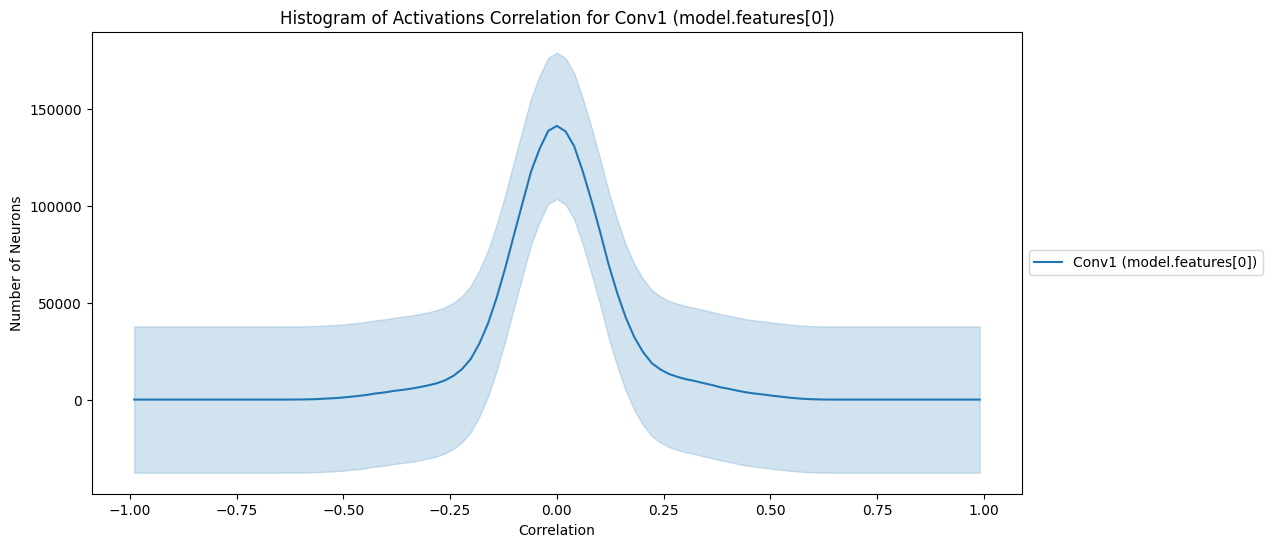

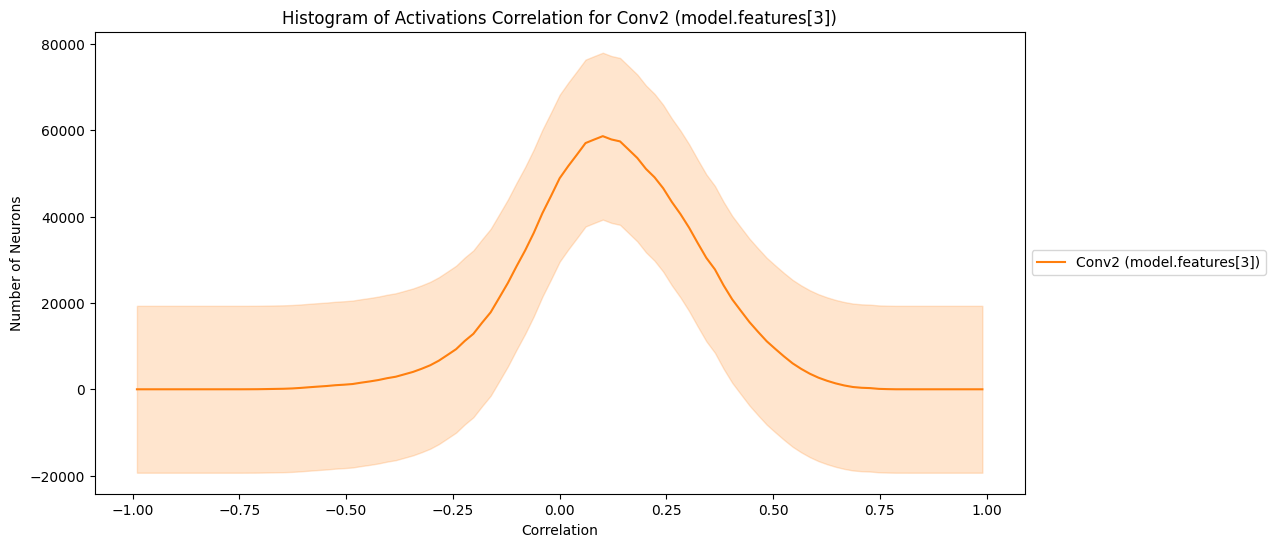

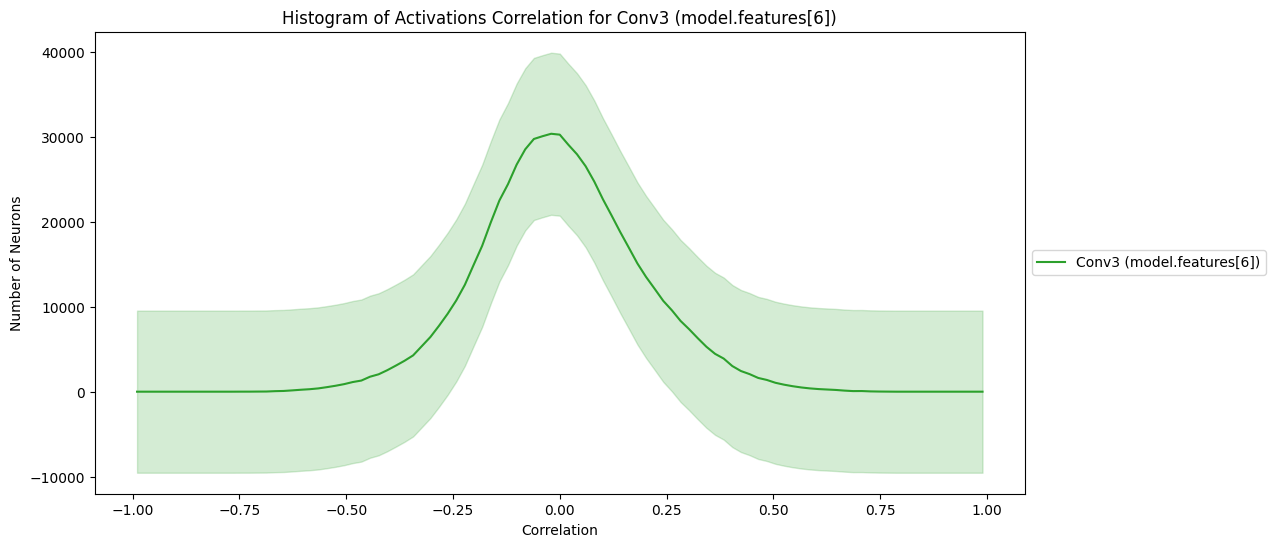

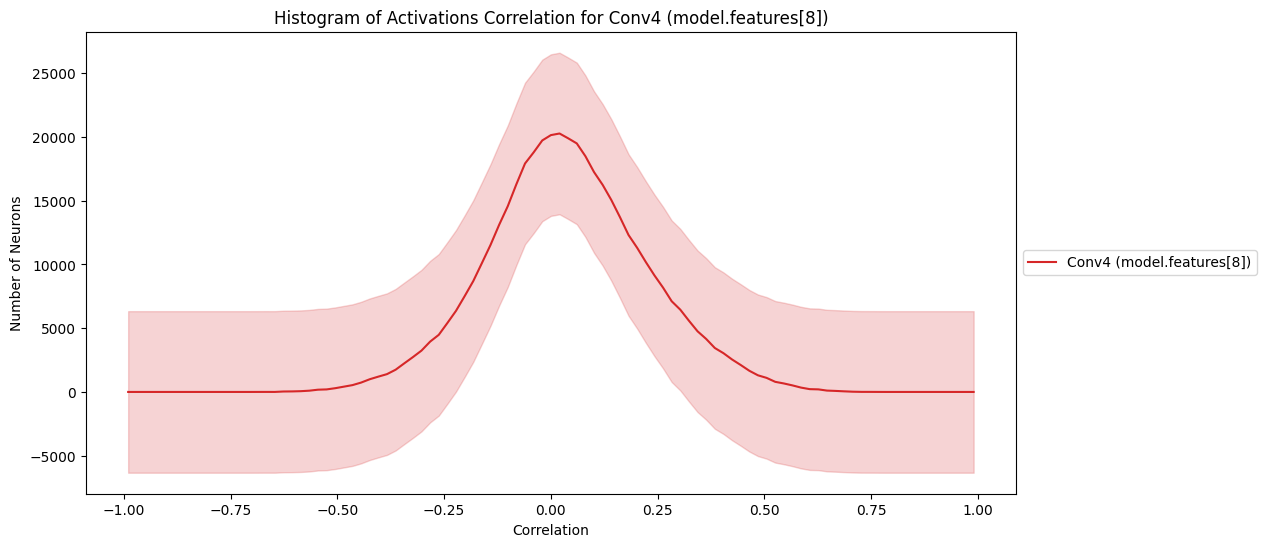

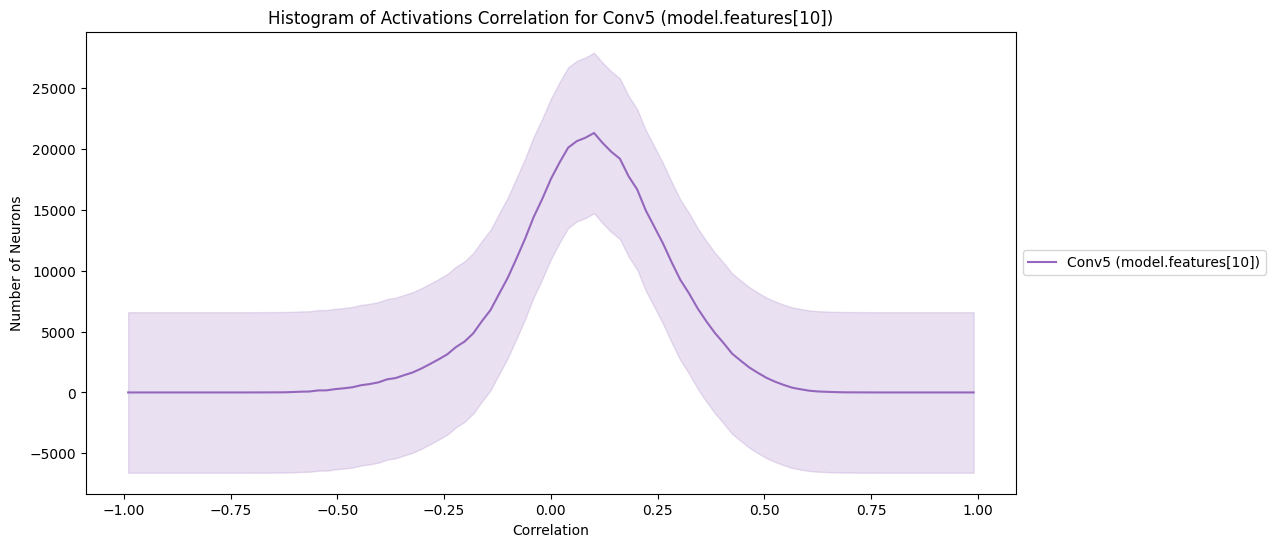

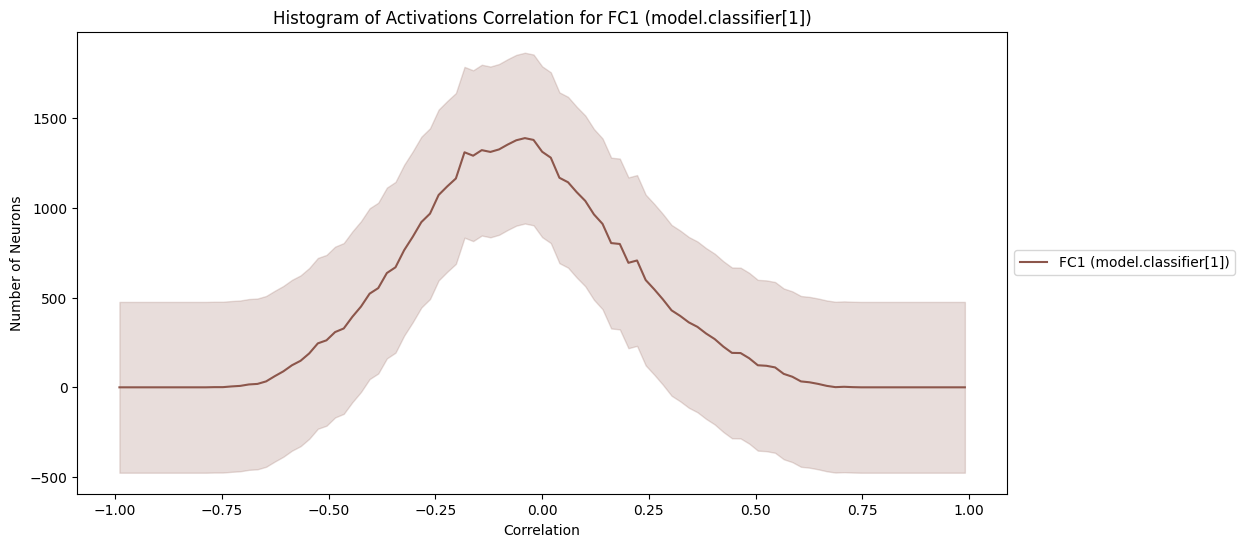

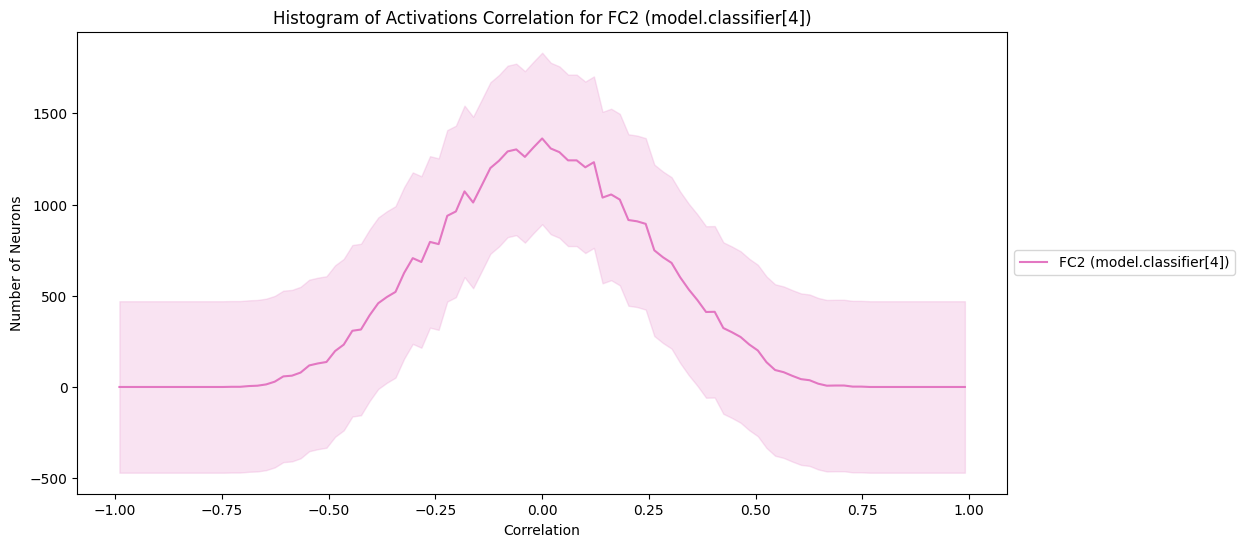

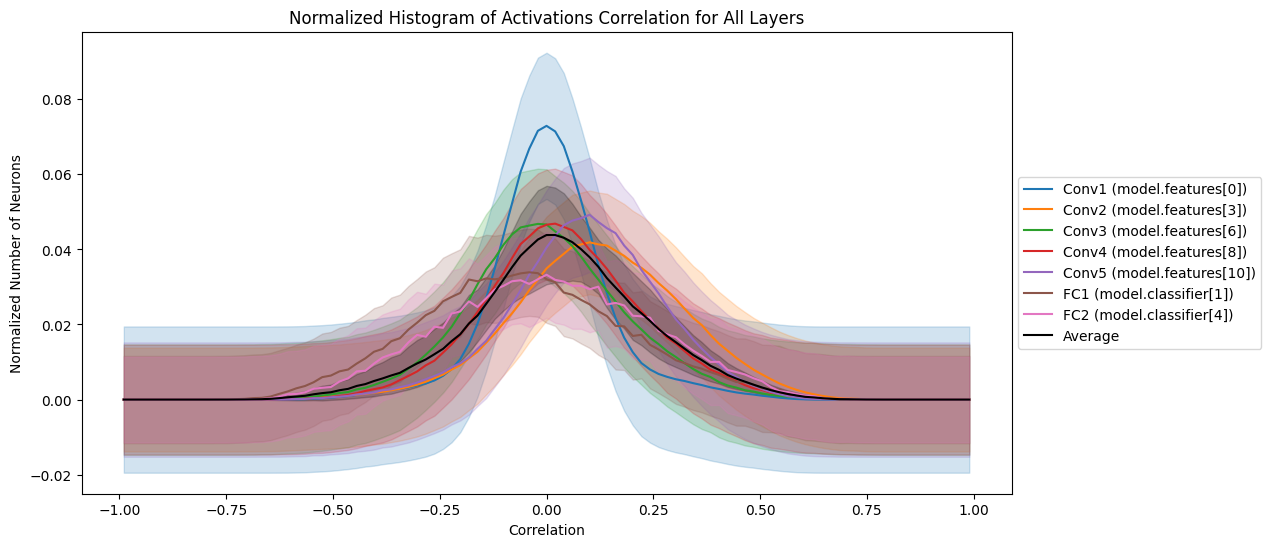

In [ ]:
import os
import numpy as np
import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import gc
from scipy.stats import pearsonr
from torch.utils.data import DataLoader, Dataset

# Custom dataset class for loading images
class ImageDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path)
        if self.transform:
            image = self.transform(image)
        return image

# Load and prepare the model
def load_model(model_path):
    model = models.alexnet(pretrained=False)
    model.classifier[-1] = torch.nn.Linear(4096, 2)
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()
    return model

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Preprocessing function
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def preprocess_and_extract_activations(model, dataloader, layer):
    activations = []
    with torch.no_grad():
        for image_tensor in dataloader:
            image_tensor = image_tensor.to(device)

            if layer < 13:  # Layer in model.features
                tensor = image_tensor
                for idx, layer_module in enumerate(model.features[:layer + 1]):
                    tensor = layer_module(tensor)
            else:  # Layer in model.classifier
                tensor = model.features(image_tensor)
                tensor = model.avgpool(tensor)
                tensor = torch.flatten(tensor, 1)
                for idx, layer_module in enumerate(model.classifier[:layer - 12]):
                    tensor = layer_module(tensor)

            activation = tensor.cpu().numpy()
            activations.append(activation)

    return activations

def process_images_in_folder(model, folder_path, layer, batch_size=10):
    all_layer_activations = []

    image_paths = [os.path.join(root, file)
                   for root, dirs, files in os.walk(folder_path)
                   for file in files if file.endswith('.jpg')]

    dataset = ImageDataset(image_paths, transform=preprocess)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    activations = preprocess_and_extract_activations(model, dataloader, layer)
    all_layer_activations.extend(activations)
    torch.cuda.empty_cache()
    gc.collect()

    return all_layer_activations

def flatten_and_align_activations(activations_list):
    # Flatten activations and find the maximum length
    flat_activations = [act.flatten() for act in activations_list]
    max_length = max(len(act) for act in flat_activations)

    # Pad or truncate activations to the maximum length
    aligned_activations = []
    for activation in flat_activations:
        if len(activation) < max_length:
            padded_activation = np.pad(activation, (0, max_length - len(activation)), 'constant')
        else:
            padded_activation = activation[:max_length]
        aligned_activations.append(padded_activation)
    return np.vstack(aligned_activations)

def save_activations(all_layer_activations, filename):
    drive_path = f'/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/activations/{filename}'
    np.save(drive_path, all_layer_activations)

def load_activations(filename):
    drive_path = f'/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/activations/{filename}'
    return np.load(drive_path, allow_pickle=True).item()

def compute_activations_for_layers(model_paths, patch_folder, no_patch_folder, layers, activations_file='activations.npy'):
    if os.path.exists(f'/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/activations/{activations_file}'):
        print(f"Loading activations from {activations_file}")
        return load_activations(activations_file)

    print(f"Computing activations and saving to {activations_file}")
    all_layer_activations = {layer: {'wp': [], 'wo': []} for layer in layers}

    for model_path in model_paths:
        model = load_model(model_path)
        for layer in layers:
            wp_activations = process_images_in_folder(model, patch_folder, layer)
            wo_activations = process_images_in_folder(model, no_patch_folder, layer)
            all_layer_activations[layer]['wp'].append(flatten_and_align_activations(wp_activations))
            all_layer_activations[layer]['wo'].append(flatten_and_align_activations(wo_activations))
        del model  # Free model resources after use
        torch.cuda.empty_cache()
        gc.collect()

    save_activations(all_layer_activations, activations_file)
    return all_layer_activations

def compute_avg_std_activations(all_layer_activations, layers):
    layer_avg_std = {layer: {'wp_avg': None, 'wo_avg': None, 'wp_std': None, 'wo_std': None} for layer in layers}

    for layer in layers:
        wp_all_models_layer_activations = np.stack(all_layer_activations[layer]['wp'], axis=0)
        wo_all_models_layer_activations = np.stack(all_layer_activations[layer]['wo'], axis=0)

        wp_avg = np.mean(wp_all_models_layer_activations, axis=0)
        wo_avg = np.mean(wo_all_models_layer_activations, axis=0)
        wp_std = np.std(wp_all_models_layer_activations, axis=0)
        wo_std = np.std(wo_all_models_layer_activations, axis=0)

        layer_avg_std[layer]['wp_avg'] = wp_avg
        layer_avg_std[layer]['wo_avg'] = wo_avg
        layer_avg_std[layer]['wp_std'] = wp_std
        layer_avg_std[layer]['wo_std'] = wo_std

    return layer_avg_std

def plot_histogram_for_layer(layer_avg_std, layer, layer_name, color):
    wp_avg = layer_avg_std[layer]['wp_avg']
    wo_avg = layer_avg_std[layer]['wo_avg']
    wp_std = layer_avg_std[layer]['wp_std']
    wo_std = layer_avg_std[layer]['wo_std']

    x = np.linspace(start=-1, stop=1, num=100)
    xaxis = x + (x[1] - x[0]) / 2
    xaxis = xaxis[:-1]

    patch_no_patch = np.hstack([np.zeros(len(wo_avg)), np.ones(len(wp_avg))])
    combined_activations = np.vstack((wo_avg, wp_avg))

    A = []
    for ii in range(combined_activations.shape[1]):
        A.append(pearsonr(patch_no_patch, combined_activations[:, ii])[0])

    B = np.histogram(A, bins=x)

    bin_means = B[0]
    bin_stds = np.std(bin_means)

    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111)
    ax.plot(xaxis, bin_means, '-', color=color, label=layer_name)
    ax.fill_between(xaxis, bin_means - bin_stds, bin_means + bin_stds, color=color, alpha=0.2)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(f'Histogram of Activations Correlation for {layer_name}')
    plt.xlabel('Correlation')
    plt.ylabel('Number of Neurons')
    plt.show()

def plot_combined_histogram(layer_avg_std, layer_names, colors):
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111)

    x = np.linspace(start=-1, stop=1, num=100)
    xaxis = x + (x[1] - x[0]) / 2
    xaxis = xaxis[:-1]

    all_layer_bin_means = []

    for idx, (layer, layer_name) in enumerate(layer_names.items()):
        wp_avg = layer_avg_std[layer]['wp_avg']
        wo_avg = layer_avg_std[layer]['wo_avg']
        wp_std = layer_avg_std[layer]['wp_std']
        wo_std = layer_avg_std[layer]['wo_std']

        patch_no_patch = np.hstack([np.zeros(len(wo_avg)), np.ones(len(wp_avg))])
        combined_activations = np.vstack((wo_avg, wp_avg))

        A = []
        for ii in range(combined_activations.shape[1]):
            A.append(pearsonr(patch_no_patch, combined_activations[:, ii])[0])

        B = np.histogram(A, bins=x)

        bin_means = B[0] / np.sum(B[0])  # Normalize the bin counts
        bin_stds = np.std(bin_means)

        all_layer_bin_means.append(bin_means)

        ax.plot(xaxis, bin_means, '-', color=colors[idx], label=layer_name)
        ax.fill_between(xaxis, bin_means - bin_stds, bin_means + bin_stds, color=colors[idx], alpha=0.2)

    # Compute average and standard deviation of the normalized histograms across layers
    all_layer_bin_means = np.array(all_layer_bin_means)
    avg_bin_means = np.mean(all_layer_bin_means, axis=0)
    std_bin_means = np.std(all_layer_bin_means, axis=0)

    ax.plot(xaxis, avg_bin_means, '-', color='black', label='Average')
    ax.fill_between(xaxis, avg_bin_means - std_bin_means, avg_bin_means + std_bin_means, color='black', alpha=0.2)

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title('Normalized Histogram of Activations Correlation for All Layers')
    plt.xlabel('Correlation')
    plt.ylabel('Normalized Number of Neurons')
    plt.show()

# Main execution
layers_of_interest = [0, 3, 6, 8, 10, 14, 17]
layer_names = {
    0: "Conv1 (model.features[0])",
    3: "Conv2 (model.features[3])",
    6: "Conv3 (model.features[6])",
    8: "Conv4 (model.features[8])",
    10: "Conv5 (model.features[10])",
    14: "FC1 (model.classifier[1])",
    17: "FC2 (model.classifier[4])"
}
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink']

patch_waterbird_folder_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/test/test_wb_patch'
no_patch_waterbird_folder_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/test/test_wb_nopatch'

model_paths = [
    "/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/models/initial_classifier/alexnet_wbw_lbl_lbw_1_train.pt",
    "/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/models/initial_classifier/alexnet_wbw_lbl_lbw_2_train.pt",
    "/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/models/initial_classifier/alexnet_wbw_lbl_lbw_3_train.pt"
]

all_layer_activations = compute_activations_for_layers(model_paths, patch_waterbird_folder_path, no_patch_waterbird_folder_path, layers_of_interest)
layer_avg_std = compute_avg_std_activations(all_layer_activations, layers_of_interest)

# Plot histograms for each layer
for idx, (layer, layer_name) in enumerate(layer_names.items()):
    plot_histogram_for_layer(layer_avg_std, layer, layer_name, colors[idx])

# Plot combined histogram for all layers
plot_combined_histogram(layer_avg_std, layer_names, colors)


Layer-wise extractions

Processing batch 1/65 for layer 0
Processing batch 2/65 for layer 0
Processing batch 3/65 for layer 0
Processing batch 4/65 for layer 0
Processing batch 5/65 for layer 0
Processing batch 6/65 for layer 0
Processing batch 7/65 for layer 0
Processing batch 8/65 for layer 0
Processing batch 9/65 for layer 0
Processing batch 10/65 for layer 0
Processing batch 11/65 for layer 0
Processing batch 12/65 for layer 0
Processing batch 13/65 for layer 0
Processing batch 14/65 for layer 0
Processing batch 15/65 for layer 0
Processing batch 16/65 for layer 0
Processing batch 17/65 for layer 0
Processing batch 18/65 for layer 0
Processing batch 19/65 for layer 0
Processing batch 20/65 for layer 0
Processing batch 21/65 for layer 0
Processing batch 22/65 for layer 0
Processing batch 23/65 for layer 0
Processing batch 24/65 for layer 0
Processing batch 25/65 for layer 0
Processing batch 26/65 for layer 0
Processing batch 27/65 for layer 0
Processing batch 28/65 for layer 0
Processing batch 29/65 for la

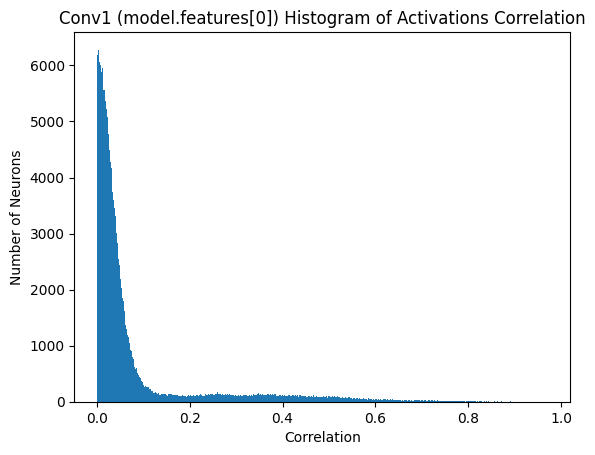

Layer 3 wp_waterbird_all_activations shape: (123264, 27, 27)
Layer 3 wo_waterbird_all_activations shape: (123264, 27, 27)


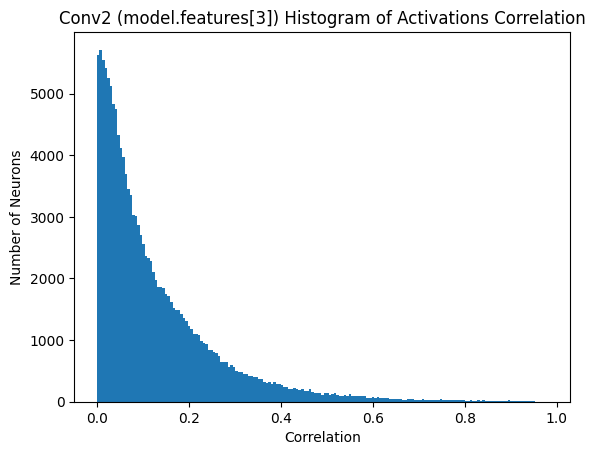

Layer 6 wp_waterbird_all_activations shape: (246528, 13, 13)
Layer 6 wo_waterbird_all_activations shape: (246528, 13, 13)


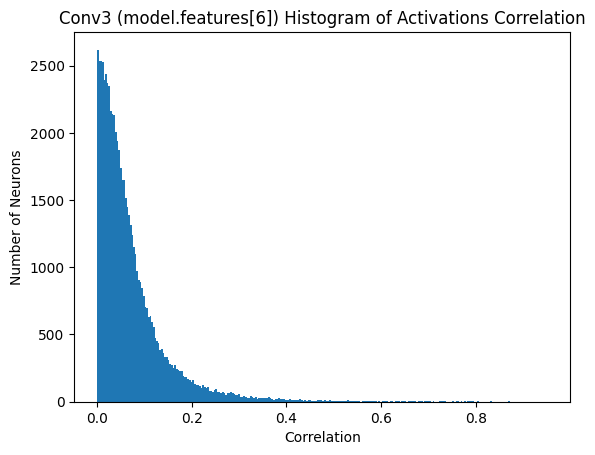

Layer 8 wp_waterbird_all_activations shape: (164352, 13, 13)
Layer 8 wo_waterbird_all_activations shape: (164352, 13, 13)


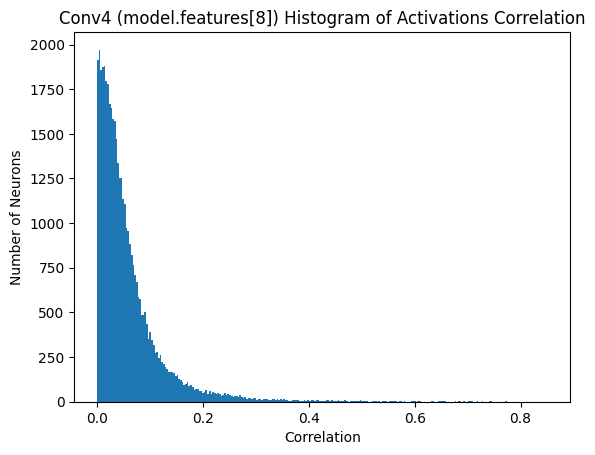

Layer 10 wp_waterbird_all_activations shape: (164352, 13, 13)
Layer 10 wo_waterbird_all_activations shape: (164352, 13, 13)


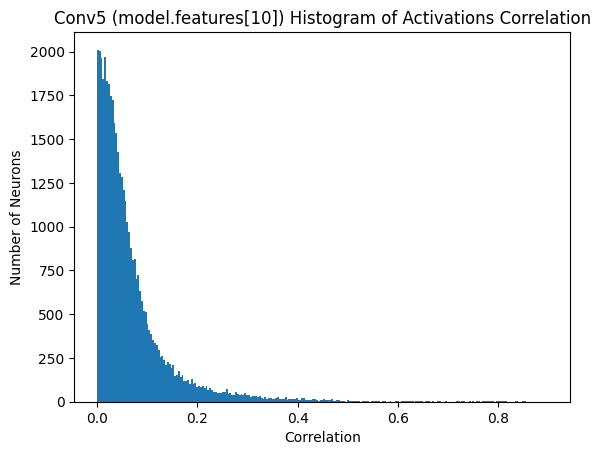

Layer 14 wp_waterbird_all_activations shape: (642, 4096)
Layer 14 wo_waterbird_all_activations shape: (642, 4096)


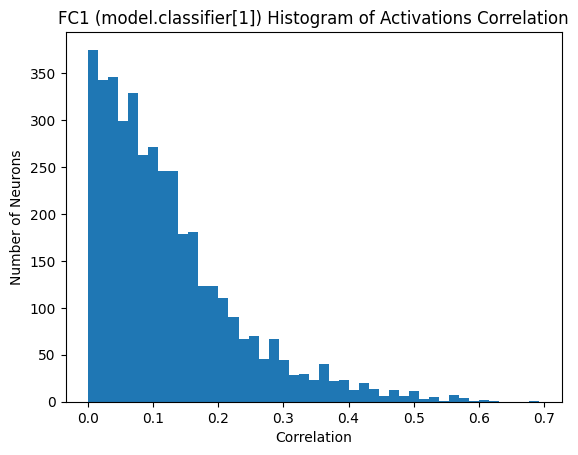

Layer 17 wp_waterbird_all_activations shape: (642, 4096)
Layer 17 wo_waterbird_all_activations shape: (642, 4096)


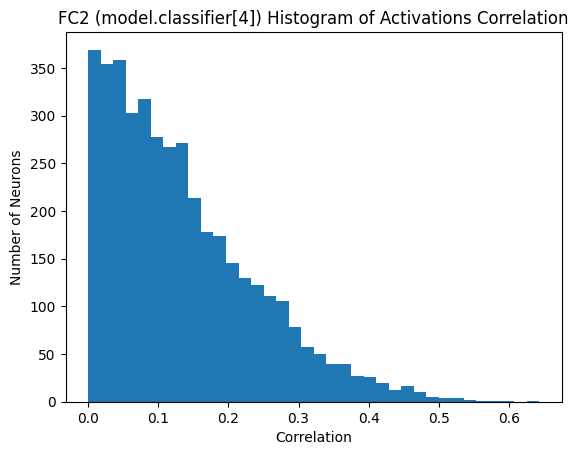

In [ ]:
import os
import numpy as np
import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import gc

# Load pre-trained alexnet model
model = models.alexnet(pretrained=True)

model.classifier[-1] = torch.nn.Linear(4096, 2)

# Load the saved parameters into the model
saved_model_path = "/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/models/initial_classifier/alexnet_wbw_lbl_lbw_3_train.pt"
model.load_state_dict(torch.load(saved_model_path))

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define preprocessing transforms
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def preprocess_and_extract_activations(image_paths, layer):
    activations = []
    with torch.no_grad():
        for image_path in image_paths:
            image = Image.open(image_path)
            image_tensor = preprocess(image).unsqueeze(0).to(device)

            if layer < 13:  # Layer in model.features
                tensor = image_tensor
                for idx, layer_module in enumerate(model.features[:layer + 1]):
                    tensor = layer_module(tensor)
            else:  # Layer in model.classifier
                tensor = model.features(image_tensor)
                tensor = model.avgpool(tensor)
                tensor = torch.flatten(tensor, 1)
                for idx, layer_module in enumerate(model.classifier[:layer - 12]):
                    tensor = layer_module(tensor)

            activation = tensor.squeeze().cpu().numpy()
            activations.append(activation)

    return activations

def process_images_in_folder(folder_path, layers, batch_size=10):
    all_layer_activations = {layer: [] for layer in layers}

    image_paths = [os.path.join(root, file)
                   for root, dirs, files in os.walk(folder_path)
                   for file in files if file.endswith('.jpg')]

    for layer in layers:
        for i in range(0, len(image_paths), batch_size):
            batch_paths = image_paths[i:i + batch_size]
            print(f"Processing batch {i // batch_size + 1}/{(len(image_paths) - 1) // batch_size + 1} for layer {layer}")

            activations = preprocess_and_extract_activations(batch_paths, layer)
            if activations is not None:
                all_layer_activations[layer].extend(activations)
            else:
                print(f"Failed to process batch {i // batch_size + 1}")

            torch.cuda.empty_cache()
            gc.collect()

    return all_layer_activations

# Define layers of interest
layers_of_interest = [0, 3, 6, 8, 10, 14, 17]  # Indices of layers in model.features and model.classifier

# Folder paths for images
patch_waterbird_folder_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/test/test_wb_patch'
no_patch_waterbird_folder_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/test/test_wb_nopatch'

# Process images in folders for each layer
wp_waterbird_all_activations = process_images_in_folder(patch_waterbird_folder_path, layers_of_interest)
wo_waterbird_all_activations = process_images_in_folder(no_patch_waterbird_folder_path, layers_of_interest)

# Layer names corresponding to the indices in layers_of_interest
layer_names = {
    0: "Conv1 (model.features[0])",
    3: "Conv2 (model.features[3])",
    6: "Conv3 (model.features[6])",
    8: "Conv4 (model.features[8])",
    10: "Conv5 (model.features[10])",
    14: "FC1 (model.classifier[1])",
    17: "FC2 (model.classifier[4])"
}

# Generate histograms for each layer
for layer_idx in layers_of_interest:
    wp_activations = wp_waterbird_all_activations[layer_idx]
    wo_activations = wo_waterbird_all_activations[layer_idx]

    if wp_activations:
        print(f"Layer {layer_idx} wp_waterbird_all_activations shape:", np.vstack(wp_activations).shape)
    else:
        print(f"Layer {layer_idx} No activations found in wp_waterbird_all_activations")

    if wo_activations:
        print(f"Layer {layer_idx} wo_waterbird_all_activations shape:", np.vstack(wo_activations).shape)
    else:
        print(f"Layer {layer_idx} No activations found in wo_waterbird_all_activations")

    if wp_activations and wo_activations:
        wp_activations_array = np.vstack(wp_activations).reshape(len(wp_activations), -1)
        wo_activations_array = np.vstack(wo_activations).reshape(len(wo_activations), -1)

        # Combine activations with patch/no-patch labels
        patch_no_patch = np.hstack([np.zeros(len(wo_activations_array)), np.ones(len(wp_activations_array))])
        combined_activations = np.concatenate((patch_no_patch[:, np.newaxis], np.vstack((wo_activations_array, wp_activations_array))), axis=1)

        # Calculate correlation matrix in chunks to save memory
        chunk_size = 1000
        activations_corr = []
        for start in range(0, combined_activations.shape[1], chunk_size):
            end = min(start + chunk_size, combined_activations.shape[1])
            corr_chunk = np.corrcoef(combined_activations[:, start:end], rowvar=False)
            activations_corr.append(np.abs(corr_chunk[0, 1:]))

        activations_corr = np.concatenate(activations_corr)

        # Plot histogram
        hist, bins = np.histogram(activations_corr, bins='auto')
        plt.bar(bins[:-1], hist, width=np.diff(bins), align='edge')
        plt.title(f'{layer_names[layer_idx]} Histogram of Activations Correlation')
        plt.xlabel('Correlation')
        plt.ylabel('Number of Neurons')
        plt.show()

        # Clear activations after use
        del wp_activations
        del wo_activations
        del wp_activations_array
        del wo_activations_array
        gc.collect()

## Extracting activations: T-tests

Single sample t test. Activations not normalized

Layer 0:
  WP Activations:
    Mean: [ 0.25150597 -0.7399239  -0.9293898  ... -0.01142251 -0.2237336
 -0.08500909]
    T-statistic: [  1.75674639  -8.13901118 -12.69049092 ...  -0.20207181  -3.61868924
  -1.50711558]
    P-value: [8.05387093e-02 4.71248935e-14 2.91991868e-27 ... 8.40072328e-01
 3.77690214e-04 1.33407674e-01]
  WO Activations:
    Mean: [-0.25336784 -0.60642487 -0.20218313 ... -0.46132788 -0.0750628
 -0.15198481]
    T-statistic: [-1.70210576 -4.05403873 -1.55233212 ... -3.957863   -0.89478736
 -1.33815081]
    P-value: [9.03373790e-02 7.28364610e-05 1.22212590e-01 ... 1.06049476e-04
 3.72009563e-01 1.82413595e-01]
Layer 3:
  WP Activations:
    Mean: [ 2.0787616   0.49101236  0.13283679 ... -9.079723   -7.693445
 -4.77224   ]
    T-statistic: [  6.70784922   2.96025631   0.65913968 ... -11.89814361 -11.13035452
  -9.74977919]
    P-value: [2.10871840e-10 3.45715082e-03 5.10587698e-01 ... 7.21493486e-25
 1.42989285e-22 1.56949975e-18]
  WO Activations:
    Mean: [  5.74

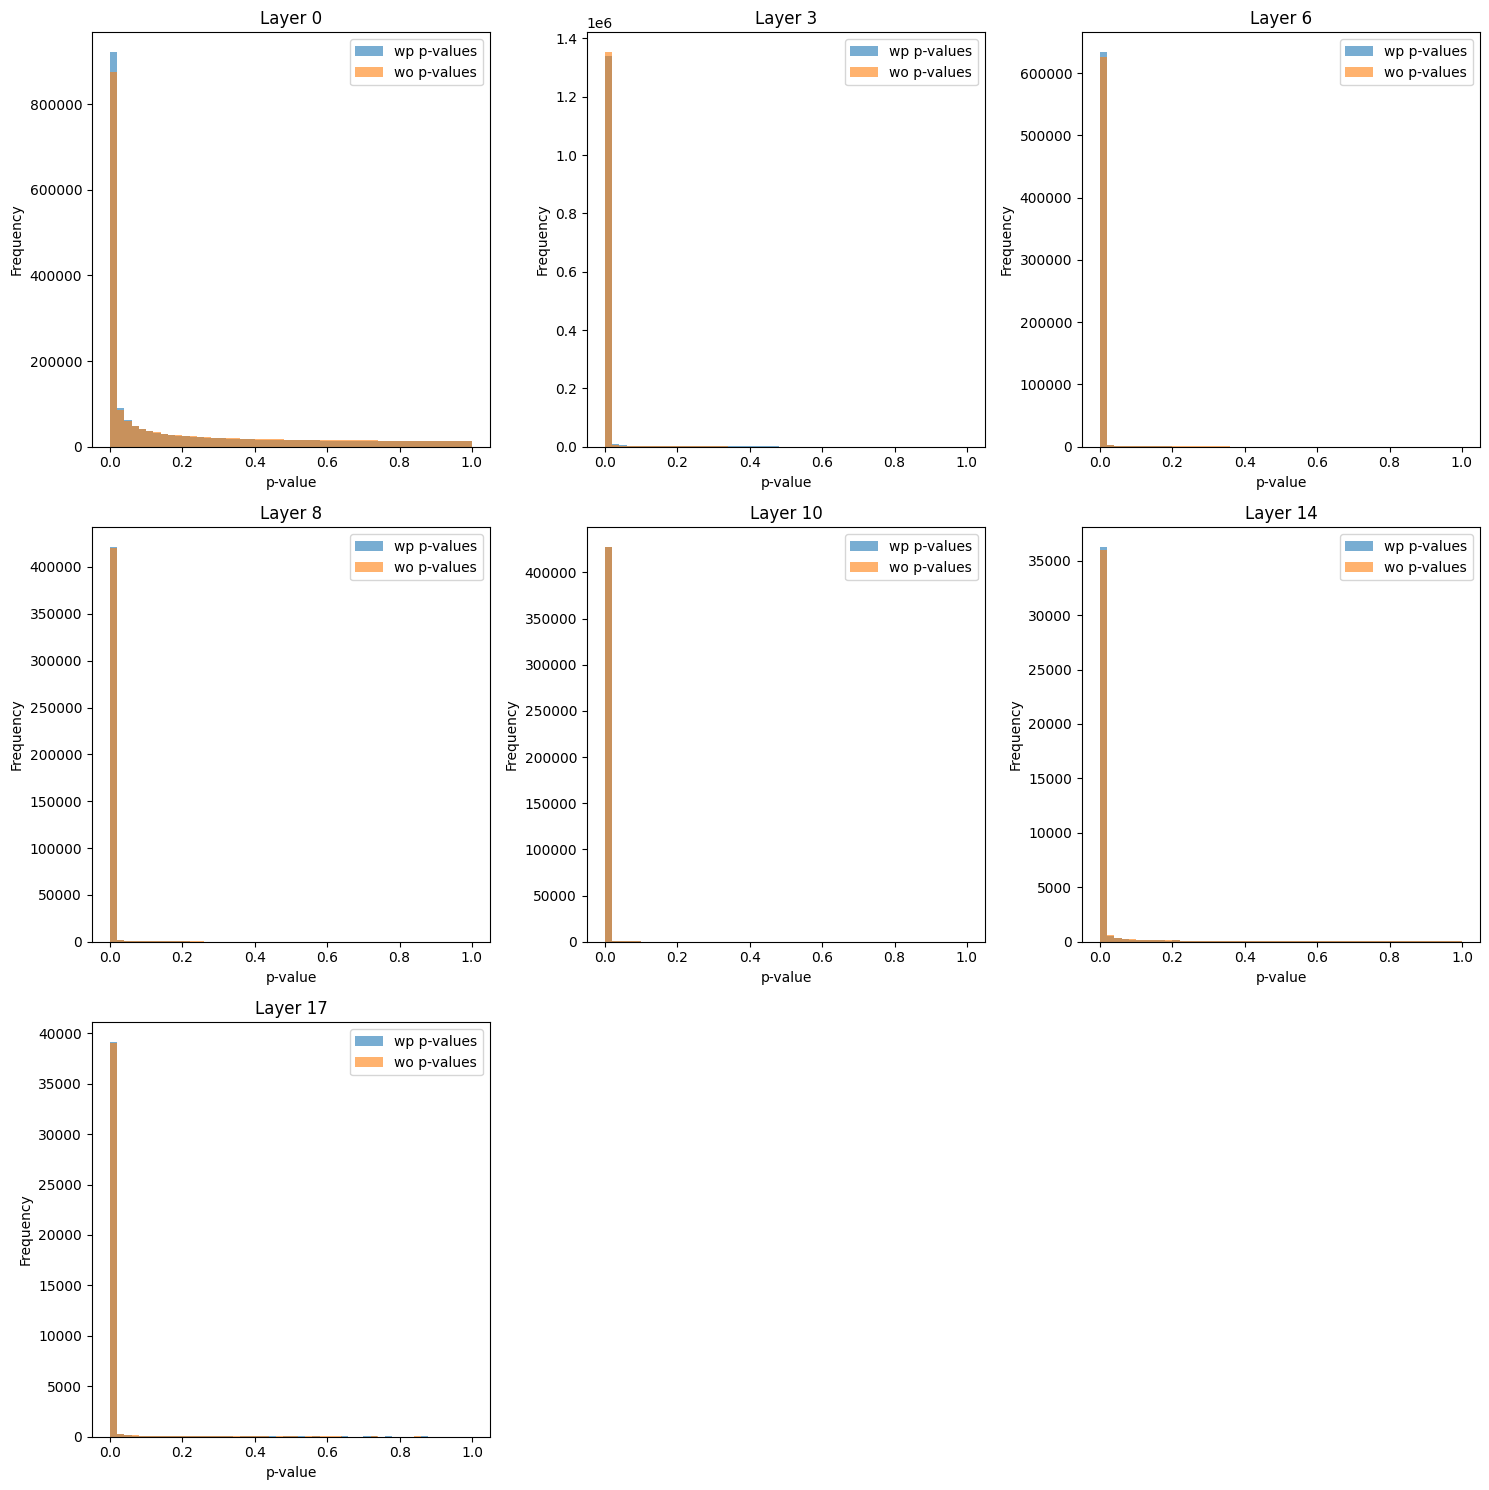

In [ ]:
from scipy.stats import ttest_1samp

# Load activations
def load_activations(filename):
    drive_path = f'/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/activations/{filename}'
    return np.load(drive_path, allow_pickle=True).item()

# Load the activations
activations_file = 'activations.npy'
all_layer_activations = load_activations(activations_file)

# Perform t-tests
def perform_t_tests(activations):
    t_test_results = {}
    for layer, data in activations.items():
        wp_activations = np.vstack(data['wp'])  # Combine all activations for wp across models
        wo_activations = np.vstack(data['wo'])  # Combine all activations for wo across models

        wp_ttest = ttest_1samp(wp_activations, 0, axis=0)  # t-test for wp activations
        wo_ttest = ttest_1samp(wo_activations, 0, axis=0)  # t-test for wo activations

        t_test_results[layer] = {
            'wp_ttest': wp_ttest,
            'wo_ttest': wo_ttest,
            'wp_means': np.mean(wp_activations, axis=0),
            'wo_means': np.mean(wo_activations, axis=0)
        }
    return t_test_results

t_test_results = perform_t_tests(all_layer_activations)

# Print t-test results
def print_t_test_results(t_test_results):
    for layer, results in t_test_results.items():
        wp_means = results['wp_means']
        wo_means = results['wo_means']
        wp_ttest = results['wp_ttest']
        wo_ttest = results['wo_ttest']

        print(f"Layer {layer}:")
        print("  WP Activations:")
        print(f"    Mean: {wp_means}")
        print(f"    T-statistic: {wp_ttest.statistic}")
        print(f"    P-value: {wp_ttest.pvalue}")
        print("  WO Activations:")
        print(f"    Mean: {wo_means}")
        print(f"    T-statistic: {wo_ttest.statistic}")
        print(f"    P-value: {wo_ttest.pvalue}")

print_t_test_results(t_test_results)

# Plot the p-values to visualize significance
def plot_p_values(t_test_results):
    num_layers = len(t_test_results)
    num_cols = 3
    num_rows = (num_layers + num_cols - 1) // num_cols  # Calculate rows needed for the number of columns

    plt.figure(figsize=(15, 5 * num_rows))  # Adjust figure size as needed
    for idx, (layer, results) in enumerate(t_test_results.items()):
        wp_p_values = results['wp_ttest'].pvalue
        wo_p_values = results['wo_ttest'].pvalue

        ax = plt.subplot(num_rows, num_cols, idx + 1)
        ax.hist(wp_p_values, bins=50, alpha=0.6, label='wp p-values')
        ax.hist(wo_p_values, bins=50, alpha=0.6, label='wo p-values')
        ax.set_title(f'Layer {layer}')
        ax.set_xlabel('p-value')
        ax.set_ylabel('Frequency')
        ax.legend()
    plt.tight_layout()
    plt.show()

plot_p_values(t_test_results)


Single sample t test. Activations normalized

In [ ]:


# Load activations
def load_activations(filename):
    drive_path = f'/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/activations/{filename}'
    return np.load(drive_path, allow_pickle=True).item()

# Normalize activations by the number of neurons in each layer
def normalize_activations_by_neurons(activations):
    normalized_activations = {}
    for layer, data in activations.items():
        wp_activations = np.vstack(data['wp'])
        wo_activations = np.vstack(data['wo'])

        num_neurons = wp_activations.shape[1]  # Number of neurons in the layer
        wp_normalized = wp_activations / num_neurons
        wo_normalized = wo_activations / num_neurons

        normalized_activations[layer] = {'wp': wp_normalized, 'wo': wo_normalized}

    return normalized_activations

# Perform t-tests
def perform_t_tests(activations):
    t_test_results = {}
    for layer, data in activations.items():
        wp_activations = data['wp']
        wo_activations = data['wo']

        wp_ttest = ttest_1samp(wp_activations, 0, axis=0)
        wo_ttest = ttest_1samp(wo_activations, 0, axis=0)

        t_test_results[layer] = {
            'wp_ttest': wp_ttest,
            'wo_ttest': wo_ttest,
            'wp_means': np.mean(wp_activations, axis=0),
            'wo_means': np.mean(wo_activations, axis=0)
        }
    return t_test_results

# Print t-test results
def print_t_test_results(t_test_results):
    for layer, results in t_test_results.items():
        wp_means = results['wp_means']
        wo_means = results['wo_means']
        wp_ttest = results['wp_ttest']
        wo_ttest = results['wo_ttest']

        print(f"Layer {layer}:")
        print("  WP Activations:")
        print(f"    Mean: {wp_means.mean():.4f}")
        print(f"    T-statistic: {wp_ttest.statistic.mean():.4f}")
        print(f"    P-value: {wp_ttest.pvalue.mean():.4f}")
        print("  WO Activations:")
        print(f"    Mean: {wo_means.mean():.4f}")
        print(f"    T-statistic: {wo_ttest.statistic.mean():.4f}")
        print(f"    P-value: {wo_ttest.pvalue.mean():.4f}")
        print("-" * 50)

# Plot the p-values to visualize significance
def plot_p_values(t_test_results):
    num_layers = len(t_test_results)
    num_cols = 3
    num_rows = (num_layers + num_cols - 1) // num_cols

    plt.figure(figsize=(15, 5 * num_rows))
    for idx, (layer, results) in enumerate(t_test_results.items()):
        wp_p_values = results['wp_ttest'].pvalue
        wo_p_values = results['wo_ttest'].pvalue

        ax = plt.subplot(num_rows, num_cols, idx + 1)
        ax.hist(wp_p_values, bins=50, alpha=0.6, label='wp p-values')
        ax.hist(wo_p_values, bins=50, alpha=0.6, label='wo p-values')
        ax.set_title(f'Layer {layer}')
        ax.set_xlabel('p-value')
        ax.set_ylabel('Frequency')
        ax.legend()
    plt.tight_layout()
    plt.show()

# Main execution
activations_file = 'activations.npy'
all_layer_activations = load_activations(activations_file)
normalized_activations = normalize_activations_by_neurons(all_layer_activations)
t_test_results = perform_t_tests(normalized_activations)
print_t_test_results(t_test_results)
plot_p_values(t_test_results)


Two sample t test with normalized activations

Layer 0:
  WP Activations:
    Mean: -0.0000
  WO Activations:
    Mean: -0.0000
  T-Test:
    T-statistic: 0.1672
    P-value: 0.2713
--------------------------------------------------
Layer 3:
  WP Activations:
    Mean: -0.0000
  WO Activations:
    Mean: -0.0000
  T-Test:
    T-statistic: 2.5421
    P-value: 0.1368
--------------------------------------------------
Layer 6:
  WP Activations:
    Mean: -0.0000
  WO Activations:
    Mean: -0.0000
  T-Test:
    T-statistic: 0.0102
    P-value: 0.1809
--------------------------------------------------
Layer 8:
  WP Activations:
    Mean: -0.0000
  WO Activations:
    Mean: -0.0000
  T-Test:
    T-statistic: 0.7848
    P-value: 0.1820
--------------------------------------------------
Layer 10:
  WP Activations:
    Mean: -0.0000
  WO Activations:
    Mean: -0.0000
  T-Test:
    T-statistic: 1.8052
    P-value: 0.1617
--------------------------------------------------
Layer 14:
  WP Activations:
    Mean: -0.0001
  WO Activations:
    M

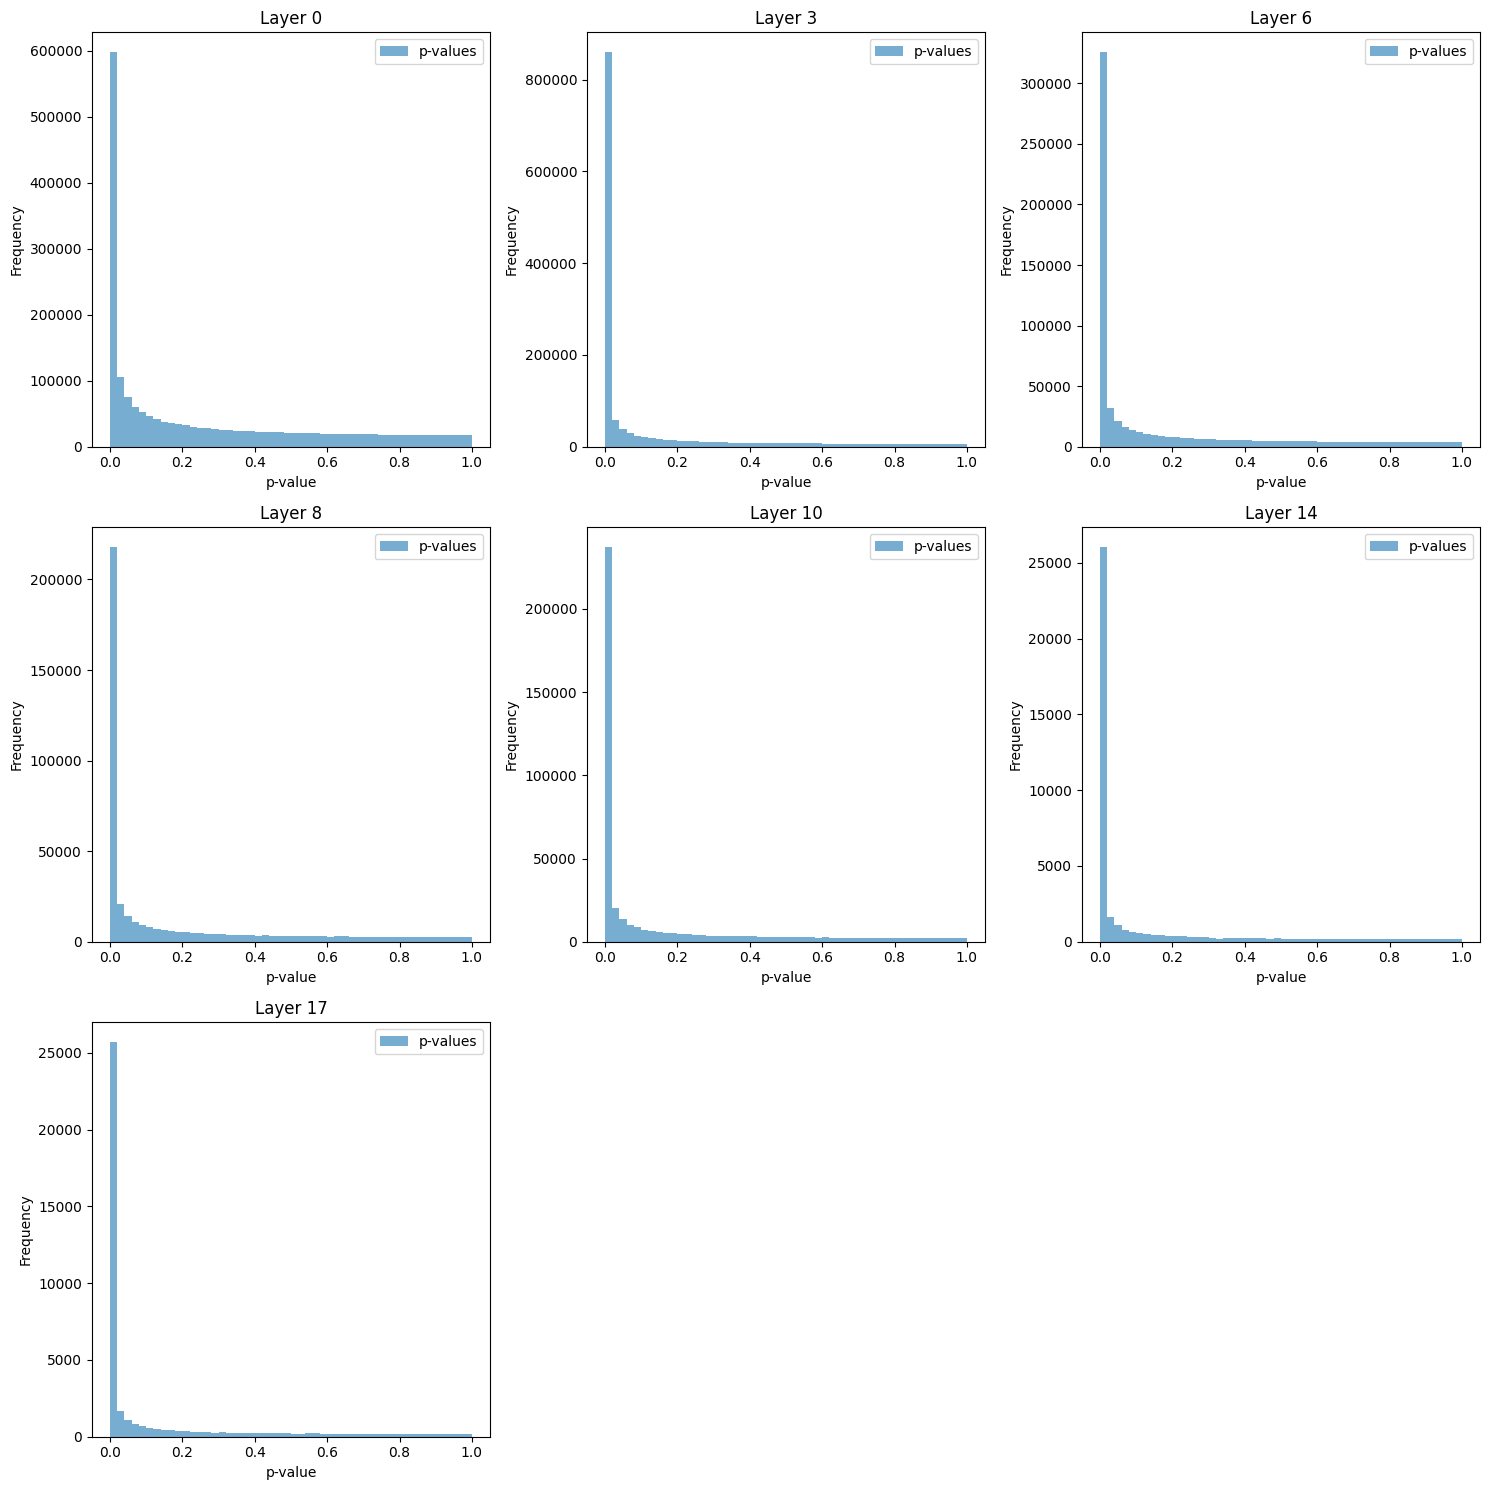

In [ ]:
from scipy.stats import ttest_ind

# Load activations
def load_activations(filename):
    drive_path = f'/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/activations/{filename}'
    return np.load(drive_path, allow_pickle=True).item()

# Normalize activations by the number of neurons in each layer
def normalize_activations_by_neurons(activations):
    normalized_activations = {}
    for layer, data in activations.items():
        wp_activations = np.vstack(data['wp'])
        wo_activations = np.vstack(data['wo'])

        num_neurons = wp_activations.shape[1]  # Number of neurons in the layer
        wp_normalized = wp_activations / num_neurons
        wo_normalized = wo_activations / num_neurons

        normalized_activations[layer] = {'wp': wp_normalized, 'wo': wo_normalized}

    return normalized_activations

# Perform two-sample t-tests comparing neuron activations
def perform_two_sample_t_tests(activations):
    t_test_results = {}
    for layer, data in activations.items():
        wp_activations = data['wp']
        wo_activations = data['wo']

        # Perform two-sample t-test for each neuron
        ttest_result = ttest_ind(wp_activations, wo_activations, axis=0)

        t_test_results[layer] = {
            'ttest': ttest_result,
            'wp_means': np.mean(wp_activations, axis=0),
            'wo_means': np.mean(wo_activations, axis=0)
        }
    return t_test_results

# Print t-test results
def print_t_test_results(t_test_results):
    for layer, results in t_test_results.items():
        wp_means = results['wp_means']
        wo_means = results['wo_means']
        ttest = results['ttest']

        print(f"Layer {layer}:")
        print("  WP Activations:")
        print(f"    Mean: {wp_means.mean():.4f}")
        print("  WO Activations:")
        print(f"    Mean: {wo_means.mean():.4f}")
        print("  T-Test:")
        print(f"    T-statistic: {ttest.statistic.mean():.4f}")
        print(f"    P-value: {ttest.pvalue.mean():.4f}")
        print("-" * 50)

# Plot the p-values to visualize significance
def plot_p_values(t_test_results):
    num_layers = len(t_test_results)
    num_cols = 3
    num_rows = (num_layers + num_cols - 1) // num_cols

    plt.figure(figsize=(15, 5 * num_rows))
    for idx, (layer, results) in enumerate(t_test_results.items()):
        p_values = results['ttest'].pvalue

        ax = plt.subplot(num_rows, num_cols, idx + 1)
        ax.hist(p_values, bins=50, alpha=0.6, label='p-values')
        ax.set_title(f'Layer {layer}')
        ax.set_xlabel('p-value')
        ax.set_ylabel('Frequency')
        ax.legend()
    plt.tight_layout()
    plt.show()

# Main execution
activations_file = 'activations.npy'
all_layer_activations = load_activations(activations_file)
normalized_activations = normalize_activations_by_neurons(all_layer_activations)
t_test_results = perform_two_sample_t_tests(normalized_activations)
print_t_test_results(t_test_results)
plot_p_values(t_test_results)

Two sample t test without normalizing activations

Layer 0:
  WP Activations:
    Mean: -0.3512
  WO Activations:
    Mean: -0.3709
  T-Test:
    T-statistic: 0.1672
    P-value: 0.2713
    Percentage of neurons with p-value <= 0.05: 38.36%
    Percentage of neurons with p-value <= 0.02: 30.87%
--------------------------------------------------
Layer 3:
  WP Activations:
    Mean: -5.6558
  WO Activations:
    Mean: -8.0456
  T-Test:
    T-statistic: 2.5421
    P-value: 0.1368
    Percentage of neurons with p-value <= 0.05: 67.02%
    Percentage of neurons with p-value <= 0.02: 61.45%
--------------------------------------------------
Layer 6:
  WP Activations:
    Mean: -6.7119
  WO Activations:
    Mean: -6.6866
  T-Test:
    T-statistic: 0.0102
    P-value: 0.1809
    Percentage of neurons with p-value <= 0.05: 56.92%
    Percentage of neurons with p-value <= 0.02: 50.21%
--------------------------------------------------
Layer 8:
  WP Activations:
    Mean: -4.4207
  WO Activations:
    Mean: -4.7966
  T-Test:
    T-statistic: 0.78

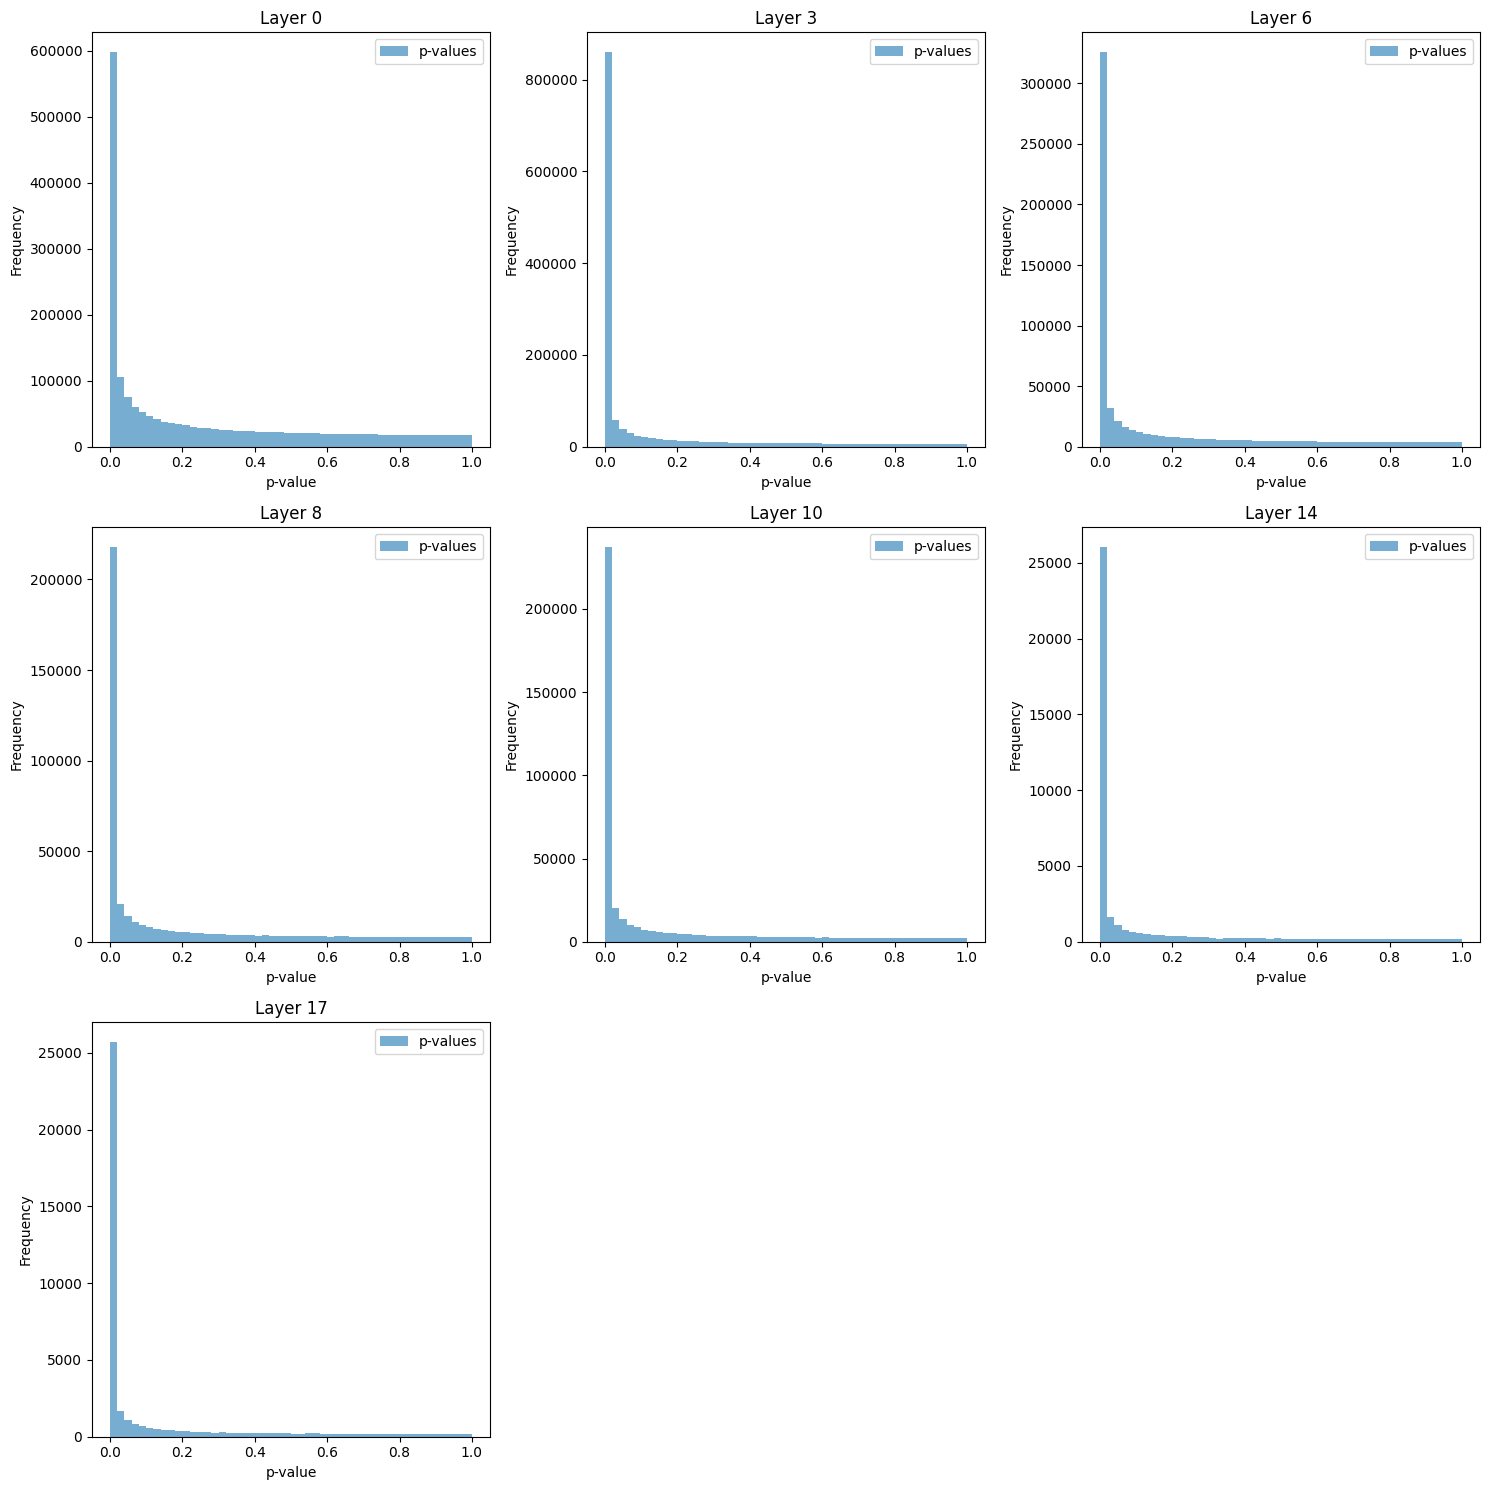

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

# Load activations
def load_activations(filename):
    drive_path = f'/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/activations/{filename}'
    return np.load(drive_path, allow_pickle=True).item()

# Perform two-sample t-tests comparing neuron activations
def perform_two_sample_t_tests(activations):
    t_test_results = {}
    for layer, data in activations.items():
        wp_activations = np.vstack(data['wp'])
        wo_activations = np.vstack(data['wo'])

        # Perform two-sample t-test for each neuron
        ttest_result = ttest_ind(wp_activations, wo_activations, axis=0)

        t_test_results[layer] = {
            'ttest': ttest_result,
            'wp_means': np.mean(wp_activations, axis=0),
            'wo_means': np.mean(wo_activations, axis=0)
        }
    return t_test_results

# Print t-test results with percentages of neurons below or equal to specific p-values
def print_t_test_results(t_test_results):
    for layer, results in t_test_results.items():
        wp_means = results['wp_means']
        wo_means = results['wo_means']
        ttest = results['ttest']

        # Calculate the percentage of neurons below or equal to specific p-value thresholds
        p_values = ttest.pvalue
        below_or_equal_0_05 = np.mean(p_values <= 0.05) * 100
        below_or_equal_0_02 = np.mean(p_values <= 0.02) * 100

        print(f"Layer {layer}:")
        print("  WP Activations:")
        print(f"    Mean: {wp_means.mean():.4f}")
        print("  WO Activations:")
        print(f"    Mean: {wo_means.mean():.4f}")
        print("  T-Test:")
        print(f"    T-statistic: {ttest.statistic.mean():.4f}")
        print(f"    P-value: {ttest.pvalue.mean():.4f}")
        print(f"    Percentage of neurons with p-value <= 0.05: {below_or_equal_0_05:.2f}%")
        print(f"    Percentage of neurons with p-value <= 0.02: {below_or_equal_0_02:.2f}%")
        print("-" * 50)

# Plot the p-values to visualize significance
def plot_p_values(t_test_results):
    num_layers = len(t_test_results)
    num_cols = 3
    num_rows = (num_layers + num_cols - 1) // num_cols

    plt.figure(figsize=(15, 5 * num_rows))
    for idx, (layer, results) in enumerate(t_test_results.items()):
        p_values = results['ttest'].pvalue

        ax = plt.subplot(num_rows, num_cols, idx + 1)
        ax.hist(p_values, bins=50, alpha=0.6, label='p-values')
        ax.set_title(f'Layer {layer}')
        ax.set_xlabel('p-value')
        ax.set_ylabel('Frequency')
        ax.legend()
    plt.tight_layout()
    plt.show()

# Main execution
activations_file = 'activations.npy'
all_layer_activations = load_activations(activations_file)
t_test_results = perform_two_sample_t_tests(all_layer_activations)
print_t_test_results(t_test_results)
plot_p_values(t_test_results)

In [ ]:
# Print some of the raw activations before normalization
print("Raw WP Activations for Layer 0 (first 5 samples):")
print(np.vstack(all_layer_activations[0]['wp'])[:5])
print("Raw WO Activations for Layer 0 (first 5 samples):")
print(np.vstack(all_layer_activations[0]['wo'])[:5])

# Print some of the normalized activations
print("Normalized WP Activations for Layer 0 (first 5 samples):")
print(normalized_activations[0]['wp'][:5])
print("Normalized WO Activations for Layer 0 (first 5 samples):")
print(normalized_activations[0]['wo'][:5])

Raw WP Activations for Layer 0 (first 5 samples):
[[-1.4902291   0.60352093 -0.18414408 ...  0.2958988  -0.3694883
   0.32905126]
 [ 1.8651605  -0.4073612  -0.39563888 ... -0.05606402  0.00730407
  -0.15157539]
 [-3.6577551  -2.608285   -2.7135718  ... -0.10267714 -0.19931838
  -0.38585848]
 [ 1.9024434  -0.11696351 -0.14169347 ... -0.28894722 -0.24146864
  -0.828106  ]
 [-0.9414981  -0.8964129  -0.8428617  ...  1.9012445   1.1057887
   1.5148426 ]]
Raw WO Activations for Layer 0 (first 5 samples):
[[-2.0522254   0.05503196 -1.547636   ... -1.1783278  -0.5119229
  -0.08902866]
 [ 2.0556161   2.0809183  -2.7527232  ... -1.6457182   0.41160005
  -1.9351993 ]
 [-1.1929371   0.00754261  0.1433869  ...  0.7151173   0.11882435
  -1.7105209 ]
 [ 0.8895088  -1.2143263   0.66405433 ... -2.500392   -0.14567377
   2.1621592 ]
 [-5.3937993   1.6827652   0.21790475 ... -0.3206971  -0.6034551
  -0.11948705]]
Normalized WP Activations for Layer 0 (first 5 samples):
[[-7.69746451e-07  3.11736017e-07 -

In [ ]:
# Load activations
def load_activations(filename):
    drive_path = f'/content/drive/MyDrive/Masterthesis/Datasets/knee_50/activations/{filename}'
    return np.load(drive_path, allow_pickle=True).item()

# Compute statistics for activations
def compute_statistics(activations):
    stats = {}
    for layer, data in activations.items():
        wp_activations = np.vstack(data['wp'])
        wo_activations = np.vstack(data['wo'])

        stats[layer] = {
            'WP Mean': np.mean(wp_activations),
            'WP Std': np.std(wp_activations),
            'WP Min': np.min(wp_activations),
            'WP Max': np.max(wp_activations),
            'WO Mean': np.mean(wo_activations),
            'WO Std': np.std(wo_activations),
            'WO Min': np.min(wo_activations),
            'WO Max': np.max(wo_activations)
        }

    return stats

# Print statistics neatly using pandas DataFrame
def print_statistics(stats):
    df = pd.DataFrame.from_dict(stats, orient='index')
    pd.set_option('display.max_columns', None)
    print(df)

# Main execution
activations_file = 'activations.npy'
all_layer_activations = load_activations(activations_file)
statistics = compute_statistics(all_layer_activations)
print_statistics(statistics)

     WP Mean    WP Std    WP Min    WP Max   WO Mean    WO Std     WO Min  \
0   0.045036  1.128982 -6.859195  6.194119  0.054010  1.349367 -10.715878   
3  -0.219394  0.984250 -6.962213  5.891632 -0.265288  1.215381 -12.446364   
6  -0.117316  0.841343 -9.031873  5.150605 -0.141146  1.135125 -19.171154   
8  -0.178989  0.641568 -5.173647  5.574313 -0.214712  0.888203 -10.552176   
10 -0.351300  0.362732 -3.740661  2.331563 -0.429252  0.552910  -7.998019   
14 -0.000396  0.236909 -1.738415  1.754016  0.000444  0.513133  -2.836332   
17  0.009075  0.241364 -1.609570  1.813463  0.016450  0.522140  -2.609701   

       WO Max  
0   10.671535  
3   12.301123  
6   12.540991  
8   10.790687  
10   6.432892  
14   2.771856  
17   2.789934  


## Archived: Extracting activations from Last FC Layer



---



In [ ]:
# Load pre-trained alexnet model
#model = models.alexnet(pretrained=True)
model = models.alexnet(weights=None)

# Modify the classifier
model.classifier[-1] = torch.nn.Linear(4096, 2)

# Load the saved parameters into the model
saved_model_path = "/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/models/initial_classifier/20240710123002selective_train_full_model.pt"
model.load_state_dict(torch.load(saved_model_path))

# Move model to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define preprocessing transforms
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def preprocess_and_extract_activations(image_path):
    # Load and preprocess the image
    image = Image.open(image_path)
    image_tensor = preprocess(image).unsqueeze(0).to(device)

    # Flatten the tensor before passing it to the linear layers
    image_tensor = model.features(image_tensor)
    image_tensor = model.avgpool(image_tensor)
    image_tensor = torch.flatten(image_tensor, 1)  # Flatten the tensor

    # Pass the tensor through the first 5 layers
    for layer_idx, layer in enumerate(model.classifier[:4], start=1):
        image_tensor = layer(image_tensor)

    # Extract activations from the sixth linear layer
    activations = model.classifier[4](image_tensor)
    activations = activations.squeeze().cpu().detach().numpy()
    #print("Activation size:", activations.shape)

    return activations

# Function to recursively traverse folders and process images
def process_images_in_folder(folder_path):
    all_activations = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith(('.jpg')):
                image_path = os.path.join(root, file)
                activations = preprocess_and_extract_activations(image_path)
                if activations is not None:
                    all_activations.append(activations)
    return all_activations

# Folder path containing images
#patch_waterbird_folder_path = "/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/waterbirds_patch_224"
#no_patch_waterbird_folder_path = "/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/waterbirds_nopatch_224"
patch_waterbird_folder_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/test/test_wb_patch'
no_patch_waterbird_folder_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/test/test_wb_nopatch'

# Extract activations for all images in the folder
wp_waterbird_all_activations = process_images_in_folder(patch_waterbird_folder_path)
wo_waterbird_all_activations = process_images_in_folder(no_patch_waterbird_folder_path)

if wp_waterbird_all_activations:
    print("wp_waterbird_all_activations shape:", np.vstack(wp_waterbird_all_activations).shape)
else:
    print("No activations found in wp_waterbird_all_activations")

if wo_waterbird_all_activations:
    print("wo_waterbird_all_activations shape:", np.vstack(wo_waterbird_all_activations).shape)
else:
    print("No activations found in wo_waterbird_all_activations")

In [ ]:
import os
import numpy as np
import torch
from torchvision import models, transforms
from PIL import Image

# Load pre-trained alexnet model
model = models.alexnet(weights=None)

# Modify the classifier
model.classifier[-1] = torch.nn.Linear(4096, 2)

# Load the saved parameters into the model
saved_model_path = "/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/models/initial_classifier/20240710123002selective_train_full_model.pt"
model.load_state_dict(torch.load(saved_model_path))

# Move model to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define preprocessing transforms
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def preprocess_and_extract_activations(image_path):
    try:
        # Load and preprocess the image
        image = Image.open(image_path)
        print(f"Image loaded: {image_path}")  # Debug: Check if image is loaded
        # unsqueeze(0) adds an extra dimension to simulate a batch of size 1
        image_tensor = preprocess(image).unsqueeze(0).to(device)
        print(f"Image preprocessed: {image_tensor.shape}")  # Debug: Check the tensor shape

        # Flatten the tensor before passing it to the linear layers
        image_tensor = model.features(image_tensor)
        print(f"Features extracted: {image_tensor.shape}")  # Debug: Check the tensor shape after features
        image_tensor = model.avgpool(image_tensor)
        image_tensor = torch.flatten(image_tensor, 1)  # Flatten the tensor
        print(f"Tensor flattened: {image_tensor.shape}")  # Debug: Check the flattened tensor shape

        # Sequentially pass the tensor through the first five layers of the classifier
        # Pass through the classifier layers up to fc2 (model.classifier[4])
        for layer_idx, layer in enumerate(model.classifier[:5], start=1):
            if layer_idx == 5:
                break
            image_tensor = layer(image_tensor)
            print(f"Layer {layer_idx} output shape: {image_tensor.shape}")  # Debug: Check the output shape of each layer

        # Extract activations from the sixth linear layer of the classifier
        activations = model.classifier[4](image_tensor)
        activations = activations.squeeze().cpu().detach().numpy()
        print(f"Activations extracted: {activations.shape}")  # Debug: Check the activations shape
        return activations
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None

# Function to recursively traverse folders and process images
def process_images_in_folder(folder_path):
    all_activations = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith(('.jpg')):
                image_path = os.path.join(root, file)
                print(f"Processing image: {image_path}")  # Debug: print the image path being processed
                activations = preprocess_and_extract_activations(image_path)
                if activations is not None:
                    all_activations.append(activations)
                else:
                    print(f"Failed to process image: {image_path}")  # Debug: print if image processing failed
    return all_activations

# Folder path containing images
patch_waterbird_folder_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/test/test_wb_patch'
no_patch_waterbird_folder_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/test/test_wb_nopatch'

# Extract activations for all images in the folder
wp_waterbird_all_activations = process_images_in_folder(patch_waterbird_folder_path)
wo_waterbird_all_activations = process_images_in_folder(no_patch_waterbird_folder_path)

if wp_waterbird_all_activations:
    print("wp_waterbird_all_activations shape:", np.vstack(wp_waterbird_all_activations).shape)
else:
    print("No activations found in wp_waterbird_all_activations")

if wo_waterbird_all_activations:
    print("wo_waterbird_all_activations shape:", np.vstack(wo_waterbird_all_activations).shape)
else:
    print("No activations found in wo_waterbird_all_activations")


In [ ]:
# each row corresponds to the activations of one image.
#np.vstack(wp_waterbird_all_activations).shape

In [ ]:
# Save activations for malignant wit patches as npy array (Sari likes npy, I like csv)
np.save('/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/waterbird_test_wp_activations.npy',np.vstack(wp_waterbird_all_activations))
np.save('/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/waterbird_test_wo_activations.npy',np.vstack(wo_waterbird_all_activations))

In [ ]:
#folder_path = "/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/waterbirds_patch_224"
#folder_path_waterbird_patch = "/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/waterbirds_patch_224"
#folder_path_waterbird_nopatch = "/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/waterbirds_nopatch_224"
folder_path_waterbird_patch = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/test/test_wb_patch'
folder_path_waterbird_nopatch = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/dataset_splits/test/test_wb_nopatch'

files_patch= os.listdir(folder_path_waterbird_patch)
files_nopatch= os.listdir(folder_path_waterbird_nopatch)


num_waterbird_patch_test = len(files_patch)
num_waterbird_nopatch_test = len(files_nopatch)


patch_no_patch = np.hstack([np.zeros((1,num_waterbird_nopatch_test)),np.ones((1,num_waterbird_patch_test))])

wp = np.load('/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/waterbird_test_wp_activations.npy')
wo = np.load('/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/waterbird_test_wo_activations.npy')
wop_activations = np.vstack([wo,wp])

In [ ]:
wop_activations.shape

In [ ]:
two_arrays = np.concatenate((patch_no_patch.T, wop_activations), axis=1) # 900x568
corr = np.corrcoef(two_arrays.T)

In [ ]:
patch_no_patch.shape

In [ ]:
import matplotlib.pyplot as plt
activations_corr = np.abs(corr[0][1:])
_ = plt.hist(activations_corr, bins='auto')

In [ ]:
activations_corr.shape

In [ ]:
print(activations_corr)